In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'SaltID/train/'
path_test = 'SaltID/test/'

In [3]:
train_path_images = os.path.abspath("SaltID/train/images")
train_path_masks = os.path.abspath("SaltID/train/masks")
train_path_images
# images
# masks

'C:\\Users\\e.istre91\\Thinkful Projects\\SaltID\\train\\images'

In [4]:
test_path_images = os.path.abspath("SaltID/test/images")
test_path_masks = os.path.abspath("SaltID/test/masks")
test_path_images

'C:\\Users\\e.istre91\\Thinkful Projects\\SaltID\\test\\images'

In [5]:
train_path_images_list = glob(os.path.join(train_path_images, "**/*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "**/*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "**/*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "**/*.png"))

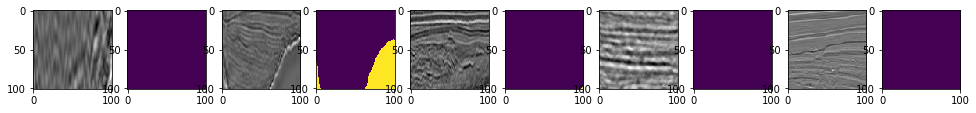

In [6]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread('SaltID/train/images/' + img_name + '.png')
    img_mask = imread('SaltID/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [7]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [8]:
depths = pd.read_csv("SaltID/depths.csv")
print(depths['z'].min(), depths['z'].max())

50 959


In [9]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        anti_aliasing=True,
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [10]:
# # Get and resize train images and masks
# X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
# print('Getting and resizing test images and masks ... ')
# sys.stdout.flush()
# for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
#     img = imread(path_test + '/images/' + id_)
#     x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
#     X_test[n] = x

# print('Done!')

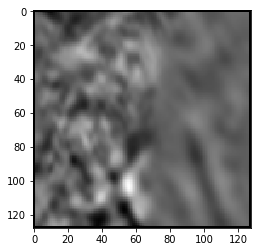

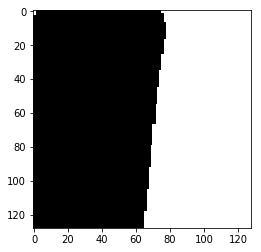

In [11]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [12]:
# # Check if training data looks all right
# ix = random.randint(0, len(test_ids))
# plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
# plt.show()

In [13]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [14]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)/255
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [15]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.int64)

#X_test_shaped = X_test.astype(np.float32)

In [16]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [17]:
indices = list(range(len(X_train_shaped)))
np.random.shuffle(indices)

val_size = 0
split = np.int_(np.floor(val_size * len(X_train_shaped)))

train_idxs = indices[split:]
val_idxs = indices[:split]

In [18]:
len(X_train_shaped)

4000

In [36]:
Y_train_shaped = Y_train_shaped[:,0,:,:]

In [37]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped)
salt_ID_dataset_val = saltIDDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped)
#salt_ID_dataset_test = saltIDDataset(X_test_shaped, train=False)

batch_size = 32
n_iters = 8000
num_epochs = n_iters / (len(X_train_shaped) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

# test_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test, 
#                                           batch_size=batch_size, 
#                                           shuffle=False)

In [38]:
num_epochs

64

In [39]:
def conv_relu(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

def double_conv(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size,
                          stride, padding),
                nn.ReLU())

start_fm = 16

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1 (?)
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, start_fm, 
                                        3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 
                                        3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 
                                        3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 
                                        3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 
                                        3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 
                                          2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        #self.final_act = nn.LogSoftmax()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)
        #print(conv1.size(), maxpool1.size())

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        #print(conv2.size(), maxpool2.size())

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        #print(conv3.size(), maxpool3.size())

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
        #print(conv4.size(), maxpool4.size())
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        #print(conv5.size())
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        #print(t_conv4.size(), ex_conv4.size())
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)
        #print(t_conv3.size(), ex_conv3.size())

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        #print(t_conv2.size(), ex_conv2.size())
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        #print(t_conv1.size(), ex_conv1.size())
        
        one_by_one = self.one_by_one(ex_conv1)
        #print(one_by_one.size())
        #final = self.final_act(one_by_one)
        
        #final = torch.where((final > .5).cuda(), ones, zeros)
        
        return one_by_one

In [48]:
model = Unet()
model.cuda();

In [49]:
criterion = nn.CrossEntropyLoss()

In [50]:
learning_rate = 0.0001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [51]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

In [52]:
ones = torch.ones(batch_size, 1, 128, 128).cuda()
zeros = torch.zeros(batch_size, 1, 128, 128).cuda()

In [53]:
zeros.shape

torch.Size([32, 1, 128, 128])

In [54]:
zeros.select(1, 0).shape

torch.Size([32, 128, 128])

In [64]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(train_loader):        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        #print(outputs, masks)
        
        #print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
                
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 100 == 0:
            
            t_scores = []
            # Iterate through test dataset
            for threshold in [.1]: #, .55, .6, .65, .7, .75, .8, .85, .9, .95]:
                true_pos = 0
                false_pos = 0
                false_neg = 0
                true_neg = 0
                #print(threshold)
                for val_images, val_masks in train_loader:

                    val_images = Variable(val_images.cuda())
                    val_masks = val_masks.cuda()

                    val_outputs = model(val_images)
                    print(val_outputs, val_outputs.shape)
                    
                    bin_outputs = torch.where(val_outputs > .5, 
                                              ones, 
                                              zeros).byte()
                    #print(bin_outputs)
                    bin_masks = val_masks.byte()
                    
                    for bin_output, bin_mask in zip(bin_outputs, bin_masks):
                        #print(bin_output | bin_mask)
                        #print(bin_output & bin_mask)
                        union = (bin_output | bin_mask).sum()
                        inter = (bin_output & bin_mask).sum()
                        if inter > 0:
                            print(union, inter)
                        if inter == 0:
                            iou = 0
                        else:
                            iou = inter / union
                        
                        #print("iou", iou)
                        
                        mask_obj = bin_mask.any()
                        output_obj = bin_output.any()
                        
                        if output_obj:
                            print(bin_output)
                        
                        if iou > threshold:
                            true_pos += 1
                        elif iou <= threshold and mask_obj:
                            false_neg += 1
                        elif iou <= threshold and output_obj:
                            false_pos += 1
                        elif not mask_obj and not output_obj:
                            true_neg += 1
                        else:
                            print("freak out")
                
                print(true_pos, false_pos, false_neg, true_neg)
                t_score = true_pos / (true_pos + false_pos + false_neg)
                    
                t_scores.append(t_score)

            # Print Loss
            print('Iteration: {}. Loss: {}. Mean IU: {}'.format(iter, loss.data.item(), np.mean(t_scores)))

tensor(1.00000e-02 *
       [[[[-1.7510, -1.5952, -1.8548,  ..., -1.7312, -1.8280, -1.8259],
          [-1.3624, -0.8081, -0.8882,  ..., -0.6190, -1.4852, -1.1821],
          [-1.6994, -1.6172, -1.3716,  ..., -1.1733, -1.4997, -1.1131],
          ...,
          [-2.1028, -2.2406, -2.2171,  ..., -1.5011, -1.4388, -1.1682],
          [-2.1254, -2.1764, -2.2790,  ..., -1.5539, -1.4392, -1.2048],
          [-2.1635, -2.4991, -2.5539,  ..., -2.1244, -2.0841, -1.5474]]],


        [[[-1.6764, -1.5631, -1.8400,  ..., -1.7277, -1.7282, -1.7522],
          [-1.2729, -0.7787, -0.7540,  ..., -0.7838, -1.3322, -1.1827],
          [-1.6898, -1.8015, -1.3835,  ..., -1.3099, -1.3699, -1.1466],
          ...,
          [-2.0854, -2.2440, -2.1706,  ..., -1.1046, -0.9728, -0.7174],
          [-2.1254, -2.1979, -2.2748,  ..., -1.5633, -1.2169, -0.9765],
          [-2.1700, -2.5345, -2.5762,  ..., -2.2610, -2.0957, -1.5724]]],


        [[[-1.6711, -1.5398, -1.8240,  ..., -1.7275, -1.7867, -1.7789],
     

          [-2.1637, -2.5491, -2.6382,  ..., -2.2775, -2.1001, -1.5994]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7302, -1.5824, -1.8326,  ..., -1.7437, -1.9283, -1.9255],
          [-1.3355, -0.8139, -0.8384,  ..., -0.5266, -1.4784, -1.1471],
          [-1.7280, -1.6888, -1.3670,  ..., -1.1555, -1.5647, -1.0404],
          ...,
          [-2.0436, -2.2830, -2.2017,  ..., -1.4518, -1.2037, -0.9597],
          [-2.0888, -2.2450, -2.3533,  ..., -1.6622, -1.4233, -1.1615],
          [-2.1714, -2.5657, -2.6612,  ..., -2.2639, -2.0984, -1.5858]]],


        [[[-1.7334, -1.5106, -1.8301,  ..., -1.6834, -1.7733, -1.7791],
          [-1.3365, -0.8904, -0.9026,  ..., -0.7337, -1.4333, -1.1858],
          [-1.5712, -1.6525, -1.4165,  ..., -1.2507, -1.5123, -1.1318],
          ...,
          [-2.0495, -2.1269, -2.0200,  ..., -1.5131, -1.3546, -0.9910],
          [-2.0974, -2.1501, -2.1083,  ..., -1.6847, -1.4836, -1.1833],
          [-2.1680, -2.4787, -2

          [-2.1710, -2.4017, -2.3374,  ..., -2.2768, -2.0951, -1.5898]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7937, -1.6467, -1.8803,  ..., -1.7680, -1.8965, -1.8748],
          [-1.4131, -0.8482, -0.9453,  ..., -0.5820, -1.4329, -1.1649],
          [-1.7746, -1.6484, -1.3693,  ..., -1.1072, -1.4197, -1.0619],
          ...,
          [-2.0129, -2.2969, -2.1747,  ..., -1.4818, -1.2020, -0.8764],
          [-2.0769, -2.2640, -2.3595,  ..., -1.7256, -1.4489, -1.1176],
          [-2.1746, -2.5789, -2.6904,  ..., -2.2900, -2.1042, -1.6037]]],


        [[[-1.6288, -1.5129, -1.8076,  ..., -1.8419, -1.8982, -1.8399],
          [-1.2222, -0.6353, -0.6741,  ..., -0.5939, -1.3164, -1.1290],
          [-1.5206, -1.6629, -1.3102,  ..., -1.1651, -1.2411, -1.0160],
          ...,
          [-1.9522, -2.1520, -1.8445,  ..., -1.3718, -1.0929, -0.7620],
          [-2.0669, -2.2324, -2.0923,  ..., -1.6798, -1.3584, -1.0583],
          [-2.1865, -2.5614, -2

          [-2.1720, -2.4965, -2.4230,  ..., -2.2854, -2.0983, -1.6121]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7771, -1.6325, -1.8718,  ..., -1.7030, -1.8380, -1.8625],
          [-1.3960, -0.8041, -0.9265,  ..., -0.5407, -1.4838, -1.2017],
          [-1.7219, -1.6020, -1.3463,  ..., -1.1050, -1.5355, -1.1211],
          ...,
          [-1.8925, -2.2714, -1.9523,  ..., -1.4063, -1.1997, -0.7001],
          [-2.0434, -2.2917, -2.2899,  ..., -1.7760, -1.4209, -1.0156],
          [-2.1805, -2.6099, -2.7658,  ..., -2.3135, -2.1334, -1.6180]]],


        [[[-1.8631, -1.6887, -1.8504,  ..., -1.7012, -1.7210, -1.7527],
          [-1.4976, -0.9354, -1.0177,  ..., -0.8047, -1.4451, -1.1838],
          [-1.8491, -1.6591, -1.3811,  ..., -1.2004, -1.5044, -1.1551],
          ...,
          [-2.0998, -2.2149, -2.0897,  ..., -1.4739, -1.2139, -0.9660],
          [-2.1374, -2.1598, -2.1697,  ..., -1.6739, -1.4226, -1.1637],
          [-2.1679, -2.4895, -2

          [-2.0549, -2.5336, -2.9602,  ..., -2.2615, -2.0918, -1.5670]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6782, -1.5358, -1.8220,  ..., -1.7432, -1.8935, -1.8887],
          [-1.2754, -0.7570, -0.7902,  ..., -0.5632, -1.4700, -1.1646],
          [-1.5823, -1.6472, -1.3749,  ..., -1.1230, -1.4976, -1.0637],
          ...,
          [-1.9958, -2.3369, -2.1600,  ..., -1.3249, -1.3031, -0.9027],
          [-2.0594, -2.2733, -2.3688,  ..., -1.6200, -1.4950, -1.1298],
          [-2.1712, -2.5767, -2.7007,  ..., -2.2535, -2.1127, -1.6343]]],


        [[[-1.6404, -1.5167, -1.8103,  ..., -1.7346, -1.8867, -1.9021],
          [-1.2248, -0.6918, -0.7196,  ..., -0.5384, -1.4620, -1.1711],
          [-1.5384, -1.7057, -1.3252,  ..., -1.1215, -1.5250, -1.0746],
          ...,
          [-1.8546, -2.3913, -2.1927,  ..., -1.2832, -1.1047, -0.7184],
          [-1.9710, -2.2642, -2.4116,  ..., -1.6488, -1.3290, -1.0182],
          [-2.1311, -2.5647, -2

          [-2.1620, -2.4350, -2.4106,  ..., -2.2674, -2.0914, -1.5867]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8046, -1.6374, -1.8517,  ..., -1.7346, -1.8149, -1.7946],
          [-1.4142, -0.8591, -0.9466,  ..., -0.6928, -1.4495, -1.1680],
          [-1.7807, -1.6326, -1.4094,  ..., -1.2075, -1.4118, -1.0881],
          ...,
          [-2.1493, -2.0826, -1.9774,  ..., -1.4856, -1.2370, -0.9852],
          [-2.1576, -2.0650, -2.0165,  ..., -1.6729, -1.4317, -1.1722],
          [-2.1696, -2.4273, -2.3747,  ..., -2.2671, -2.0943, -1.5814]]],


        [[[-1.6168, -1.4913, -1.7777,  ..., -1.7005, -1.8398, -1.8738],
          [-1.2094, -0.6551, -0.6562,  ..., -0.5447, -1.5289, -1.2022],
          [-1.5464, -1.7280, -1.2715,  ..., -1.1008, -1.5517, -1.1198],
          ...,
          [-2.0700, -2.3180, -2.3932,  ..., -1.4282, -1.1818, -0.7735],
          [-2.0978, -2.2303, -2.4345,  ..., -1.7365, -1.4380, -1.0760],
          [-2.1589, -2.5320, -2

          [-2.1664, -2.5042, -2.5322,  ..., -2.2490, -2.0889, -1.5849]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8092, -1.6511, -1.8718,  ..., -1.7186, -1.7465, -1.7557],
          [-1.4210, -0.8805, -0.9609,  ..., -0.7607, -1.3762, -1.1722],
          [-1.7921, -1.6632, -1.3937,  ..., -1.2859, -1.4611, -1.1375],
          ...,
          [-2.1239, -2.2235, -2.1322,  ..., -1.4026, -1.1092, -0.9028],
          [-2.1430, -2.1577, -2.1794,  ..., -1.6536, -1.3782, -1.1276],
          [-2.1679, -2.4785, -2.4786,  ..., -2.2721, -2.0864, -1.5805]]],


        [[[-1.7754, -1.6276, -1.8573,  ..., -1.7229, -1.7722, -1.7691],
          [-1.4000, -0.8032, -0.9363,  ..., -0.7457, -1.3990, -1.1725],
          [-1.7167, -1.5633, -1.2952,  ..., -1.2261, -1.4251, -1.1222],
          ...,
          [-2.1645, -2.1736, -2.0588,  ..., -1.4968, -1.2606, -1.0021],
          [-2.1638, -2.0863, -2.0162,  ..., -1.6768, -1.4381, -1.1811],
          [-2.1651, -2.4269, -2

          [-2.1681, -2.4611, -2.4205,  ..., -2.2808, -2.0964, -1.5924]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6395, -1.4791, -1.7874,  ..., -1.7005, -1.7965, -1.8097],
          [-1.2203, -0.7544, -0.7349,  ..., -0.6353, -1.4624, -1.1909],
          [-1.5270, -1.7105, -1.2929,  ..., -1.1967, -1.5479, -1.1453],
          ...,
          [-2.0328, -2.2628, -2.0706,  ..., -1.5132, -1.2372, -0.7333],
          [-2.1089, -2.2371, -2.2725,  ..., -1.8319, -1.4801, -1.0444],
          [-2.1740, -2.5692, -2.6124,  ..., -2.3195, -2.1345, -1.6216]]],


        [[[-1.7582, -1.6163, -1.8800,  ..., -1.7478, -1.8122, -1.7980],
          [-1.3626, -0.8294, -0.8862,  ..., -0.6578, -1.4561, -1.1722],
          [-1.7314, -1.7021, -1.4456,  ..., -1.1796, -1.4539, -1.1189],
          ...,
          [-2.0843, -2.0692, -1.9141,  ..., -1.4284, -1.1520, -0.8730],
          [-2.1137, -2.1198, -2.0038,  ..., -1.6869, -1.3907, -1.1070],
          [-2.1686, -2.4963, -2

          [-2.1636, -2.4494, -2.4133,  ..., -2.2981, -2.0931, -1.5876]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6801, -1.5499, -1.8389,  ..., -1.7145, -1.8225, -1.8370],
          [-1.2822, -0.7585, -0.8068,  ..., -0.6130, -1.5207, -1.1840],
          [-1.5979, -1.6832, -1.3514,  ..., -1.1307, -1.5120, -1.1298],
          ...,
          [-1.9504, -2.3474, -2.0455,  ..., -1.3960, -1.1302, -0.8401],
          [-2.0463, -2.2903, -2.3416,  ..., -1.6935, -1.4039, -1.0970],
          [-2.1733, -2.5871, -2.7160,  ..., -2.2801, -2.0969, -1.5993]]],


        [[[-1.7431, -1.5863, -1.8771,  ..., -1.7632, -1.8224, -1.8032],
          [-1.3621, -0.8209, -0.9005,  ..., -0.6501, -1.4388, -1.1675],
          [-1.6966, -1.6859, -1.4486,  ..., -1.1750, -1.4257, -1.1031],
          ...,
          [-2.1899, -1.8096, -1.8044,  ..., -1.3844, -1.1639, -0.8693],
          [-2.1711, -1.8767, -1.8161,  ..., -1.6674, -1.4243, -1.1095],
          [-2.1799, -2.3198, -2

          [-2.1670, -2.4849, -2.4707,  ..., -2.2578, -2.1279, -1.5980]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8951, -1.7220, -1.7585,  ..., -1.7335, -1.8122, -1.8032],
          [-1.6297, -0.9876, -0.9883,  ..., -0.6469, -1.4561, -1.1775],
          [-1.8391, -1.4031, -1.1975,  ..., -1.1789, -1.4672, -1.1197],
          ...,
          [-2.1834, -2.1915, -2.1805,  ..., -1.4051, -1.1361, -0.8825],
          [-2.1777, -2.0796, -2.1177,  ..., -1.6676, -1.4072, -1.1193],
          [-2.1660, -2.4155, -2.3734,  ..., -2.2770, -2.0973, -1.5912]]],


        [[[-1.6403, -1.4816, -1.7844,  ..., -1.7269, -1.8599, -1.8758],
          [-1.2357, -0.6868, -0.7411,  ..., -0.5612, -1.4754, -1.1899],
          [-1.5351, -1.6292, -1.3375,  ..., -1.1336, -1.5226, -1.0977],
          ...,
          [-2.0433, -2.2464, -2.2085,  ..., -1.3446, -1.1263, -0.7794],
          [-2.1073, -2.2220, -2.3570,  ..., -1.6776, -1.3651, -1.0608],
          [-2.1733, -2.5700, -2

          [-2.1683, -2.5288, -2.5750,  ..., -2.2648, -2.0941, -1.5802]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6430, -1.5297, -1.8288,  ..., -1.7294, -1.7798, -1.7714],
          [-1.2433, -0.7149, -0.6869,  ..., -0.7299, -1.3962, -1.1703],
          [-1.6457, -1.8634, -1.3949,  ..., -1.2084, -1.4129, -1.1154],
          ...,
          [-2.0469, -2.2698, -2.1721,  ..., -1.4109, -1.1432, -0.9083],
          [-2.0954, -2.2237, -2.3259,  ..., -1.6582, -1.4069, -1.1325],
          [-2.1680, -2.5500, -2.6349,  ..., -2.2732, -2.0934, -1.5890]]],


        [[[-1.8676, -1.6993, -1.8654,  ..., -1.7253, -1.7849, -1.7814],
          [-1.4933, -0.9531, -1.0154,  ..., -0.7324, -1.4527, -1.1720],
          [-1.8906, -1.7090, -1.4246,  ..., -1.1711, -1.4610, -1.1357],
          ...,
          [-2.0998, -2.1727, -2.0477,  ..., -1.4725, -1.2183, -0.9769],
          [-2.1341, -2.1473, -2.1389,  ..., -1.6676, -1.4196, -1.1677],
          [-2.1699, -2.4882, -2

          [-2.1608, -2.5684, -2.7293,  ..., -2.2671, -2.0945, -1.5930]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7971, -1.6464, -1.8759,  ..., -1.7551, -1.8800, -1.8698],
          [-1.4185, -0.8127, -0.9512,  ..., -0.5911, -1.4757, -1.1735],
          [-1.7535, -1.5941, -1.3633,  ..., -1.1458, -1.4631, -1.0784],
          ...,
          [-2.1381, -2.1240, -2.0320,  ..., -1.3830, -1.1019, -0.8133],
          [-2.1621, -2.1344, -2.1212,  ..., -1.6993, -1.3841, -1.0783],
          [-2.1751, -2.4918, -2.4580,  ..., -2.2840, -2.0936, -1.5970]]],


        [[[-1.9068, -1.7390, -1.9006,  ..., -1.7366, -1.8173, -1.8195],
          [-1.4943, -1.0532, -0.9904,  ..., -0.6291, -1.4946, -1.1895],
          [-2.0074, -1.8715, -1.6108,  ..., -1.1276, -1.5152, -1.1577],
          ...,
          [-2.1498, -2.1875, -2.1977,  ..., -1.4474, -1.2937, -1.0755],
          [-2.1617, -2.1428, -2.2420,  ..., -1.5960, -1.3963, -1.2123],
          [-2.1652, -2.4812, -2

          [-2.1671, -2.5279, -2.5986,  ..., -2.2347, -2.0730, -1.5645]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8333, -1.6637, -1.8698,  ..., -1.7169, -1.7870, -1.7807],
          [-1.4886, -0.9014, -1.0226,  ..., -0.7090, -1.4174, -1.1661],
          [-1.7542, -1.5851, -1.3677,  ..., -1.1568, -1.3882, -1.1039],
          ...,
          [-2.1952, -2.1892, -2.1941,  ..., -1.6958, -1.4189, -0.9752],
          [-2.1764, -2.1015, -2.1276,  ..., -1.8477, -1.5351, -1.1956],
          [-2.1670, -2.4266, -2.3906,  ..., -2.2983, -2.1230, -1.5923]]],


        [[[-1.7851, -1.6277, -1.8649,  ..., -1.7354, -1.8171, -1.8105],
          [-1.3874, -0.8721, -0.9084,  ..., -0.6340, -1.4583, -1.1771],
          [-1.7975, -1.7190, -1.4466,  ..., -1.1652, -1.4695, -1.1177],
          ...,
          [-2.0334, -2.2641, -2.1454,  ..., -1.7167, -1.4658, -1.0998],
          [-2.0839, -2.2020, -2.2133,  ..., -1.7307, -1.5029, -1.1997],
          [-2.1638, -2.5235, -2

          [-2.1681, -2.5059, -2.5253,  ..., -2.2544, -2.0916, -1.5728]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8035, -1.6377, -1.8596,  ..., -1.7478, -1.6708, -1.7520],
          [-1.4222, -0.8774, -0.9626,  ..., -1.0020, -1.3416, -1.2160],
          [-1.7561, -1.6390, -1.3647,  ..., -1.2984, -1.2723, -1.0768],
          ...,
          [-2.0908, -2.2189, -2.0986,  ..., -1.5056, -1.2539, -0.9776],
          [-2.1345, -2.1704, -2.2010,  ..., -1.6874, -1.4400, -1.1702],
          [-2.1681, -2.5048, -2.5194,  ..., -2.2742, -2.0954, -1.5847]]],


        [[[-1.8624, -1.6682, -1.8261,  ..., -1.7845, -1.8230, -1.7752],
          [-1.4766, -0.9414, -0.9818,  ..., -0.7205, -1.4179, -1.1608],
          [-1.8384, -1.6614, -1.4093,  ..., -1.2243, -1.3759, -1.0959],
          ...,
          [-2.1113, -2.2078, -2.0992,  ..., -1.4627, -1.1931, -0.9402],
          [-2.1413, -2.1532, -2.1721,  ..., -1.6716, -1.4213, -1.1520],
          [-2.1685, -2.4855, -2

          [-2.1684, -2.4522, -2.4155,  ..., -2.2803, -2.1110, -1.5996]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6899, -1.6290, -1.8527,  ..., -1.7334, -1.8499, -1.8450],
          [-1.2831, -0.8632, -0.7206,  ..., -0.5791, -1.5004, -1.1837],
          [-1.9026, -1.9469, -1.4104,  ..., -1.0671, -1.4677, -1.0916],
          ...,
          [-2.1435, -2.1832, -2.1200,  ..., -1.4689, -1.2130, -0.8508],
          [-2.1436, -2.1177, -2.1185,  ..., -1.7885, -1.5016, -1.1001],
          [-2.1651, -2.4437, -2.4340,  ..., -2.3196, -2.1300, -1.6245]]],


        [[[-1.8447, -1.7122, -1.8755,  ..., -1.5977, -1.9158, -1.9322],
          [-1.4577, -0.8849, -0.9428,  ..., -0.5003, -1.5808, -1.0943],
          [-1.8616, -1.6606, -1.3420,  ..., -1.1264, -1.5904, -0.9498],
          ...,
          [-2.1349, -2.2273, -2.1304,  ..., -1.3973, -1.2587, -1.0228],
          [-2.1594, -2.1766, -2.2187,  ..., -1.5988, -1.4077, -1.1918],
          [-2.1682, -2.5070, -2

          [-2.1689, -2.4969, -2.5101,  ..., -2.2707, -2.1031, -1.6124]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8016, -1.6519, -1.9106,  ..., -1.7284, -1.7977, -1.7968],
          [-1.4093, -0.8912, -0.9694,  ..., -0.6566, -1.4631, -1.1774],
          [-1.7473, -1.7106, -1.4560,  ..., -1.1156, -1.4770, -1.1434],
          ...,
          [-2.0770, -2.2678, -2.2509,  ..., -1.4142, -1.1452, -0.8938],
          [-2.1039, -2.1931, -2.3137,  ..., -1.6650, -1.4074, -1.1248],
          [-2.1612, -2.5142, -2.5923,  ..., -2.2756, -2.0961, -1.5919]]],


        [[[-1.9024, -1.7223, -1.8309,  ..., -1.7231, -1.7117, -1.7535],
          [-1.5758, -1.0071, -1.0600,  ..., -0.8775, -1.3699, -1.1913],
          [-1.9251, -1.6577, -1.3903,  ..., -1.2984, -1.3836, -1.1420],
          ...,
          [-2.1451, -2.1312, -2.0190,  ..., -1.4985, -1.2776, -1.0567],
          [-2.1541, -2.0847, -2.0633,  ..., -1.6728, -1.4262, -1.2022],
          [-2.1646, -2.4192, -2

          [-2.1723, -2.5513, -2.5970,  ..., -2.2698, -2.0827, -1.5946]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7739, -1.6300, -1.8768,  ..., -1.7271, -1.8092, -1.8004],
          [-1.3677, -0.8590, -0.8820,  ..., -0.6493, -1.4430, -1.1761],
          [-1.8371, -1.7800, -1.4940,  ..., -1.1572, -1.4521, -1.1166],
          ...,
          [-2.1573, -2.0983, -2.0244,  ..., -1.5784, -1.4136, -1.1066],
          [-2.1701, -2.0838, -2.0755,  ..., -1.6715, -1.4711, -1.2111],
          [-2.1705, -2.4613, -2.4142,  ..., -2.2986, -2.1052, -1.5880]]],


        [[[-1.5956, -1.4160, -1.7528,  ..., -1.7462, -1.8320, -1.8216],
          [-1.1564, -0.6384, -0.7181,  ..., -0.6639, -1.4734, -1.1854],
          [-1.4073, -1.5245, -1.2206,  ..., -1.2596, -1.5118, -1.1288],
          ...,
          [-1.9780, -2.3182, -2.0841,  ..., -1.4623, -1.1754, -0.8669],
          [-2.0564, -2.2609, -2.3387,  ..., -1.7342, -1.4498, -1.1086],
          [-2.1656, -2.5717, -2

          [-2.1678, -2.5043, -2.5174,  ..., -2.2799, -2.0976, -1.5920]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7908, -1.6313, -1.8627,  ..., -1.7108, -1.7274, -1.7530],
          [-1.4112, -0.8567, -0.9470,  ..., -0.7859, -1.4399, -1.1690],
          [-1.7656, -1.6407, -1.3571,  ..., -1.2410, -1.4838, -1.1532],
          ...,
          [-2.0954, -2.2577, -2.2480,  ..., -1.5783, -1.3204, -0.9943],
          [-2.1234, -2.1901, -2.3098,  ..., -1.7375, -1.4744, -1.1831],
          [-2.1649, -2.5157, -2.5771,  ..., -2.2725, -2.0993, -1.5793]]],


        [[[-1.6527, -1.5262, -1.8206,  ..., -1.7511, -1.6653, -1.7884],
          [-1.2371, -0.7202, -0.7575,  ..., -1.0175, -1.3508, -1.2691],
          [-1.5366, -1.6816, -1.3372,  ..., -1.5475, -1.4141, -1.1937],
          ...,
          [-2.0235, -2.2967, -2.1417,  ..., -1.2367, -1.1020, -0.6900],
          [-2.0844, -2.2432, -2.3182,  ..., -1.6335, -1.3280, -0.9921],
          [-2.1716, -2.5633, -2

          [-2.1647, -2.5819, -2.7585,  ..., -2.2763, -2.0857, -1.6066]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7906, -1.6448, -1.8930,  ..., -1.7394, -1.8716, -1.8793],
          [-1.4019, -0.8270, -0.9542,  ..., -0.5615, -1.4723, -1.1797],
          [-1.7253, -1.6290, -1.4173,  ..., -1.1164, -1.4962, -1.0842],
          ...,
          [-2.2232, -2.0853, -2.0982,  ..., -1.5105, -1.2373, -0.7867],
          [-2.2114, -2.0383, -2.0835,  ..., -1.7898, -1.4983, -1.0904],
          [-2.1791, -2.4155, -2.3827,  ..., -2.3174, -2.1259, -1.6325]]],


        [[[-1.6592, -1.5232, -1.8361,  ..., -1.7429, -1.7997, -1.8088],
          [-1.2933, -0.5849, -0.7886,  ..., -0.6342, -1.4184, -1.1855],
          [-1.5882, -1.5242, -1.2422,  ..., -1.3153, -1.5517, -1.1173],
          ...,
          [-2.1502, -2.1159, -1.9873,  ..., -1.2912, -1.1216, -0.9372],
          [-2.1682, -2.1010, -2.0623,  ..., -1.5853, -1.3685, -1.1485],
          [-2.1714, -2.4556, -2

          [-2.0817, -2.5458, -2.9055,  ..., -2.3011, -2.1303, -1.5767]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8418, -1.6413, -1.8619,  ..., -1.7865, -1.8191, -1.7598],
          [-1.4872, -0.9134, -1.0191,  ..., -0.7769, -1.4494, -1.1578],
          [-1.8139, -1.6494, -1.4751,  ..., -1.2649, -1.3971, -1.1070],
          ...,
          [-2.1155, -2.0538, -1.9442,  ..., -1.5537, -1.2917, -0.9243],
          [-2.1435, -2.1048, -2.0671,  ..., -1.7290, -1.4897, -1.1498],
          [-2.1762, -2.4861, -2.4447,  ..., -2.3096, -2.1114, -1.5884]]],


        [[[-1.6610, -1.5410, -1.8296,  ..., -1.7207, -1.8647, -1.8765],
          [-1.2553, -0.7273, -0.7611,  ..., -0.5596, -1.4496, -1.1909],
          [-1.5693, -1.6982, -1.3358,  ..., -1.1750, -1.5101, -1.0836],
          ...,
          [-2.0111, -2.2848, -2.2617,  ..., -1.1692, -1.0247, -0.6274],
          [-2.0497, -2.2174, -2.3268,  ..., -1.6601, -1.3038, -0.9298],
          [-2.1494, -2.5260, -2

          [-2.1691, -2.4796, -2.4816,  ..., -2.2686, -2.0955, -1.5861]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-2.0115, -1.8076, -1.8133,  ..., -1.6736, -1.7748, -1.7940],
          [-1.8534, -1.2805, -1.1442,  ..., -0.6770, -1.3757, -1.1920],
          [-2.0436, -1.6316, -1.3904,  ..., -1.3195, -1.5331, -1.1538],
          ...,
          [-1.7824, -2.3808, -1.8764,  ..., -1.5368, -1.3834, -1.1377],
          [-1.9590, -2.3245, -2.2816,  ..., -1.6481, -1.4255, -1.1977],
          [-2.1368, -2.5868, -2.8520,  ..., -2.2321, -2.0658, -1.5488]]],


        [[[-1.6954, -1.5712, -1.8402,  ..., -1.7289, -1.7962, -1.7855],
          [-1.3104, -0.7671, -0.8044,  ..., -0.7071, -1.4498, -1.1700],
          [-1.6832, -1.7037, -1.3640,  ..., -1.1642, -1.4473, -1.1255],
          ...,
          [-2.0483, -2.2215, -2.0524,  ..., -1.4353, -1.2203, -1.0193],
          [-2.1144, -2.1811, -2.1727,  ..., -1.6385, -1.4031, -1.1843],
          [-2.1669, -2.5150, -2

          [-2.1667, -2.5022, -2.5273,  ..., -2.2626, -2.0875, -1.5815]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7644, -1.6110, -1.8704,  ..., -1.7906, -1.8512, -1.8183],
          [-1.3764, -0.8336, -0.9107,  ..., -0.6535, -1.4009, -1.1605],
          [-1.7225, -1.6547, -1.3891,  ..., -1.2037, -1.3527, -1.0615],
          ...,
          [-2.0207, -2.1921, -1.9962,  ..., -1.4074, -1.1548, -0.9219],
          [-2.1206, -2.2364, -2.2460,  ..., -1.6585, -1.3922, -1.1376],
          [-2.1828, -2.5744, -2.6134,  ..., -2.2671, -2.0908, -1.5762]]],


        [[[-1.5340, -1.2999, -1.6829,  ..., -1.6823, -1.7930, -1.8133],
          [-1.0813, -0.4350, -0.4905,  ..., -0.5834, -1.4205, -1.1894],
          [-1.4987, -1.7337, -1.4088,  ..., -1.1471, -1.5157, -1.1237],
          ...,
          [-2.0983, -2.2561, -2.2753,  ..., -1.2393, -0.9647, -0.8384],
          [-2.1054, -2.1723, -2.3066,  ..., -1.5311, -1.2183, -1.0864],
          [-2.1593, -2.5020, -2

          [-2.1676, -2.5043, -2.5181,  ..., -2.2770, -2.0966, -1.5930]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8414, -1.6712, -1.8494,  ..., -1.7329, -1.7739, -1.7659],
          [-1.4802, -0.8973, -0.9989,  ..., -0.7520, -1.3983, -1.1674],
          [-1.8123, -1.6144, -1.3470,  ..., -1.2017, -1.4027, -1.1181],
          ...,
          [-2.1368, -2.1389, -2.0303,  ..., -1.6315, -1.3885, -0.8575],
          [-2.1460, -2.0916, -2.0463,  ..., -1.8298, -1.5599, -1.1344],
          [-2.1626, -2.4331, -2.3950,  ..., -2.3130, -2.1494, -1.6420]]],


        [[[-1.5980, -1.4438, -1.7958,  ..., -1.7466, -1.8880, -1.8895],
          [-1.1788, -0.7800, -0.6124,  ..., -0.5646, -1.4627, -1.1685],
          [-1.5395, -1.9254, -1.3277,  ..., -1.0986, -1.4881, -1.0673],
          ...,
          [-1.8223, -2.4330, -2.0983,  ..., -1.2430, -1.0581, -0.7547],
          [-1.9297, -2.2596, -2.3598,  ..., -1.6610, -1.3230, -1.0308],
          [-2.1143, -2.5583, -2

          [-2.1726, -2.5346, -2.5645,  ..., -2.2695, -2.0955, -1.5862]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6556, -1.4962, -1.8005,  ..., -1.7274, -1.7033, -1.7675],
          [-1.2409, -0.7328, -0.7986,  ..., -0.8262, -1.3518, -1.1986],
          [-1.5043, -1.5831, -1.2602,  ..., -1.3187, -1.4106, -1.1512],
          ...,
          [-2.0610, -2.2549, -2.2097,  ..., -1.5788, -1.2425, -0.9132],
          [-2.1008, -2.2089, -2.2817,  ..., -1.7694, -1.4557, -1.1470],
          [-2.1706, -2.5357, -2.5961,  ..., -2.2889, -2.1077, -1.5927]]],


        [[[-1.7540, -1.5677, -1.8642,  ..., -1.6857, -1.8262, -1.8361],
          [-1.3615, -0.8372, -0.9055,  ..., -0.5906, -1.5147, -1.1852],
          [-1.6726, -1.6673, -1.4956,  ..., -1.1275, -1.5255, -1.1101],
          ...,
          [-1.9049, -2.3063, -1.9667,  ..., -1.3703, -1.1419, -0.9153],
          [-2.0280, -2.2809, -2.2071,  ..., -1.6039, -1.3716, -1.1355],
          [-2.1749, -2.5576, -2

          [-2.1690, -2.5506, -2.6153,  ..., -2.3077, -2.1238, -1.6181]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6983, -1.5089, -1.7749,  ..., -1.7173, -1.7532, -1.7642],
          [-1.3017, -0.8475, -0.8434,  ..., -0.7296, -1.3374, -1.1780],
          [-1.5604, -1.6001, -1.2347,  ..., -1.2232, -1.4082, -1.1415],
          ...,
          [-2.0033, -2.1681, -1.9445,  ..., -1.5061, -1.2858, -0.9632],
          [-2.0526, -2.1799, -2.0081,  ..., -1.6775, -1.4573, -1.1658],
          [-2.1643, -2.4959, -2.4673,  ..., -2.2602, -2.1029, -1.5983]]],


        [[[-1.7665, -1.5991, -1.8344,  ..., -1.7270, -1.7270, -1.7503],
          [-1.3787, -0.8287, -0.9175,  ..., -0.8055, -1.3765, -1.1704],
          [-1.6611, -1.5584, -1.3531,  ..., -1.1975, -1.4220, -1.1327],
          ...,
          [-2.0563, -2.2838, -2.2321,  ..., -1.4119, -1.1409, -0.8278],
          [-2.0920, -2.2334, -2.3615,  ..., -1.7217, -1.4084, -1.0843],
          [-2.1694, -2.5483, -2

          [-2.1674, -2.5116, -2.5349,  ..., -2.2906, -2.1011, -1.5906]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.9388, -1.7476, -1.8200,  ..., -1.7609, -1.6620, -1.7714],
          [-1.6330, -1.0944, -1.0884,  ..., -0.9759, -1.2900, -1.2447],
          [-1.9551, -1.6681, -1.4605,  ..., -1.3423, -1.2085, -1.1800],
          ...,
          [-2.1050, -2.1475, -2.0282,  ..., -1.4490, -1.1777, -0.9125],
          [-2.1314, -2.1372, -2.1003,  ..., -1.6770, -1.4245, -1.1377],
          [-2.1690, -2.4747, -2.4505,  ..., -2.2814, -2.0981, -1.5908]]],


        [[[-1.8326, -1.6839, -1.8710,  ..., -1.7716, -1.8012, -1.7588],
          [-1.4819, -0.8669, -1.0040,  ..., -0.7756, -1.3842, -1.1580],
          [-1.8625, -1.6326, -1.3405,  ..., -1.2406, -1.3424, -1.0949],
          ...,
          [-2.0825, -2.3053, -2.2055,  ..., -1.4635, -1.2133, -0.9571],
          [-2.1160, -2.1999, -2.2186,  ..., -1.6724, -1.4374, -1.1628],
          [-2.1662, -2.4840, -2

          [-2.1698, -2.5057, -2.5140,  ..., -2.2750, -2.0953, -1.5888]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8575, -1.6903, -1.8575,  ..., -1.7222, -1.7653, -1.7653],
          [-1.4871, -0.9298, -1.0108,  ..., -0.7545, -1.3912, -1.1713],
          [-1.8932, -1.6819, -1.3788,  ..., -1.2261, -1.4184, -1.1233],
          ...,
          [-2.0706, -2.1996, -2.1422,  ..., -1.7116, -1.4696, -1.0698],
          [-2.1140, -2.1983, -2.1641,  ..., -1.7839, -1.5107, -1.1919],
          [-2.1744, -2.4703, -2.4667,  ..., -2.2559, -2.1041, -1.5833]]],


        [[[-1.7528, -1.5952, -1.8455,  ..., -1.7300, -1.7949, -1.7845],
          [-1.3609, -0.8099, -0.9074,  ..., -0.6929, -1.4332, -1.1700],
          [-1.6663, -1.5838, -1.3247,  ..., -1.1871, -1.4408, -1.1207],
          ...,
          [-1.9325, -2.3745, -2.0769,  ..., -1.1862, -1.1439, -0.9047],
          [-2.0358, -2.2835, -2.3532,  ..., -1.5797, -1.3221, -1.0936],
          [-2.1654, -2.5739, -2

          [-2.1514, -2.4411, -2.4434,  ..., -2.2778, -2.0921, -1.5820]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8192, -1.6498, -1.8673,  ..., -1.7347, -1.7675, -1.7614],
          [-1.4491, -0.9113, -0.9862,  ..., -0.7377, -1.3351, -1.1745],
          [-1.7773, -1.6704, -1.3900,  ..., -1.2495, -1.3588, -1.1408],
          ...,
          [-2.1683, -2.2313, -2.2579,  ..., -1.4721, -1.2176, -0.9715],
          [-2.1706, -2.1818, -2.2614,  ..., -1.6690, -1.4218, -1.1662],
          [-2.1702, -2.4988, -2.5258,  ..., -2.2682, -2.0949, -1.5813]]],


        [[[-1.7367, -1.5819, -1.8699,  ..., -1.7334, -1.8422, -1.8543],
          [-1.3528, -0.7993, -0.9536,  ..., -0.5864, -1.5065, -1.1907],
          [-1.6005, -1.5464, -1.3027,  ..., -1.1483, -1.5272, -1.1151],
          ...,
          [-2.0023, -2.2760, -2.0359,  ..., -1.3626, -1.1170, -0.7743],
          [-2.0932, -2.2400, -2.2481,  ..., -1.6911, -1.3746, -1.0639],
          [-2.1756, -2.5630, -2

          [-2.1722, -2.5826, -2.7066,  ..., -2.2702, -2.0901, -1.6013]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7664, -1.6317, -1.9142,  ..., -1.7558, -1.8221, -1.8094],
          [-1.3710, -0.8096, -0.8983,  ..., -0.6529, -1.4404, -1.1683],
          [-1.7414, -1.7022, -1.4741,  ..., -1.1937, -1.4292, -1.1026],
          ...,
          [-2.0335, -2.2298, -2.0735,  ..., -1.4397, -1.1397, -0.8261],
          [-2.0972, -2.2226, -2.2158,  ..., -1.6338, -1.3817, -1.1005],
          [-2.1812, -2.5553, -2.6036,  ..., -2.2377, -2.0866, -1.6102]]],


        [[[-1.7307, -1.6229, -1.8582,  ..., -1.7387, -1.8531, -1.8513],
          [-1.3364, -0.7936, -0.7850,  ..., -0.6036, -1.4927, -1.1808],
          [-1.8586, -1.7821, -1.4282,  ..., -1.1144, -1.4745, -1.0907],
          ...,
          [-2.0639, -2.2842, -2.2992,  ..., -1.2875, -1.1155, -0.7932],
          [-2.1023, -2.2221, -2.3623,  ..., -1.6551, -1.3548, -1.0621],
          [-2.1677, -2.5480, -2

          [-2.1658, -2.4510, -2.4266,  ..., -2.2747, -2.1038, -1.5853]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.9062, -1.7675, -1.9012,  ..., -1.7087, -2.0189, -1.9318],
          [-1.5289, -0.9534, -0.9996,  ..., -0.4706, -1.5333, -1.0365],
          [-1.9898, -1.7399, -1.4831,  ..., -1.3266, -1.6384, -0.9076],
          ...,
          [-1.7200, -2.4863, -1.9409,  ..., -1.4366, -1.2133, -0.9710],
          [-1.8879, -2.3027, -2.2937,  ..., -1.6612, -1.4382, -1.1697],
          [-2.0960, -2.5674, -2.9313,  ..., -2.2664, -2.1129, -1.5948]]],


        [[[-1.7982, -1.6427, -1.8763,  ..., -1.7840, -1.8349, -1.7946],
          [-1.3748, -0.8414, -0.8999,  ..., -0.6601, -1.4040, -1.1732],
          [-1.7561, -1.6860, -1.4783,  ..., -1.2533, -1.4242, -1.1050],
          ...,
          [-2.0849, -2.1713, -2.0208,  ..., -1.3616, -1.1060, -0.8421],
          [-2.1287, -2.1656, -2.1437,  ..., -1.6651, -1.3834, -1.0903],
          [-2.1753, -2.5228, -2

          [-2.1717, -2.5886, -2.6326,  ..., -2.2830, -2.1111, -1.6040]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7436, -1.5878, -1.8584,  ..., -1.7539, -1.8651, -1.8634],
          [-1.3551, -0.8101, -0.9063,  ..., -0.6083, -1.4474, -1.1732],
          [-1.6598, -1.6008, -1.3599,  ..., -1.2162, -1.4686, -1.0609],
          ...,
          [-2.0740, -2.2190, -2.0716,  ..., -1.1992, -0.9944, -0.6833],
          [-2.1358, -2.1838, -2.2226,  ..., -1.5746, -1.2611, -0.9863],
          [-2.1705, -2.5221, -2.5449,  ..., -2.2764, -2.0986, -1.5842]]],


        [[[-1.6366, -1.4889, -1.7669,  ..., -1.7438, -1.8373, -1.8562],
          [-1.2045, -0.6833, -0.6640,  ..., -0.5649, -1.4653, -1.1762],
          [-1.5466, -1.7187, -1.3579,  ..., -1.0915, -1.4855, -1.1057],
          ...,
          [-2.0519, -2.3095, -2.1860,  ..., -1.3671, -1.0906, -0.8004],
          [-2.0995, -2.2408, -2.2746,  ..., -1.7034, -1.3532, -1.0649],
          [-2.1726, -2.5407, -2

          [-2.1709, -2.5735, -2.6968,  ..., -2.2691, -2.0850, -1.5987]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7539, -1.6063, -1.8577,  ..., -1.7309, -1.8103, -1.8108],
          [-1.3674, -0.7981, -0.8706,  ..., -0.6340, -1.4803, -1.1877],
          [-1.7300, -1.6409, -1.3706,  ..., -1.1694, -1.5233, -1.1526],
          ...,
          [-2.0724, -2.2430, -2.1286,  ..., -1.4687, -1.3497, -1.1093],
          [-2.1233, -2.1978, -2.2680,  ..., -1.4847, -1.4088, -1.2378],
          [-2.1710, -2.5375, -2.5828,  ..., -2.2539, -2.1161, -1.5921]]],


        [[[-1.7019, -1.5477, -1.8595,  ..., -1.7347, -1.8661, -1.8870],
          [-1.3098, -0.7411, -0.9030,  ..., -0.5268, -1.4288, -1.1767],
          [-1.5141, -1.4868, -1.2865,  ..., -1.0536, -1.4822, -1.0780],
          ...,
          [-1.9711, -2.3671, -2.1083,  ..., -1.1235, -0.9955, -0.7306],
          [-2.0493, -2.2999, -2.3537,  ..., -1.5722, -1.2231, -0.9818],
          [-2.1752, -2.5908, -2

          [-2.1736, -2.5688, -2.6368,  ..., -2.3034, -2.1316, -1.6380]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6839, -1.5441, -1.8444,  ..., -1.7270, -1.8644, -1.8828],
          [-1.2755, -0.7233, -0.8365,  ..., -0.5506, -1.4833, -1.1902],
          [-1.5231, -1.5634, -1.3318,  ..., -1.1391, -1.5394, -1.1041],
          ...,
          [-1.8680, -2.4299, -2.1956,  ..., -1.4139, -1.1346, -0.8490],
          [-1.9606, -2.2652, -2.4266,  ..., -1.6966, -1.4101, -1.1031],
          [-2.1226, -2.5570, -2.8424,  ..., -2.2862, -2.1014, -1.6051]]],


        [[[-1.8200, -1.6567, -1.8440,  ..., -1.7428, -1.8526, -1.8538],
          [-1.4257, -0.8769, -0.9388,  ..., -0.5920, -1.4710, -1.1799],
          [-1.7849, -1.6255, -1.3585,  ..., -1.1491, -1.4592, -1.0762],
          ...,
          [-2.0931, -2.2411, -2.1437,  ..., -1.3957, -1.1259, -0.8903],
          [-2.1306, -2.1821, -2.2403,  ..., -1.6525, -1.4015, -1.1291],
          [-2.1684, -2.5095, -2

          [-2.1664, -2.4505, -2.4119,  ..., -2.2649, -2.0857, -1.5710]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6323, -1.5069, -1.8004,  ..., -1.7554, -1.8679, -1.8695],
          [-1.2138, -0.6791, -0.7049,  ..., -0.5660, -1.4694, -1.1829],
          [-1.5253, -1.6986, -1.3095,  ..., -1.1202, -1.4877, -1.0900],
          ...,
          [-1.9507, -2.3512, -2.1946,  ..., -1.3118, -1.0659, -0.7340],
          [-2.0313, -2.2677, -2.4009,  ..., -1.6479, -1.3095, -1.0324],
          [-2.1619, -2.5777, -2.7535,  ..., -2.2781, -2.0913, -1.5971]]],


        [[[-1.5888, -1.4337, -1.7782,  ..., -1.6757, -1.8860, -1.9312],
          [-1.1370, -0.6876, -0.5962,  ..., -0.5031, -1.4853, -1.1812],
          [-1.4974, -1.8445, -1.3502,  ..., -1.1518, -1.6186, -1.0843],
          ...,
          [-1.9950, -2.3248, -2.1335,  ..., -1.3016, -1.1058, -0.7180],
          [-2.0728, -2.2745, -2.3577,  ..., -1.6629, -1.3353, -1.0180],
          [-2.1746, -2.5834, -2

          [-2.1678, -2.5367, -2.6076,  ..., -2.2726, -2.1008, -1.5952]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6450, -1.5166, -1.7976,  ..., -1.7364, -1.8696, -1.8813],
          [-1.2316, -0.6960, -0.7244,  ..., -0.5635, -1.4695, -1.1821],
          [-1.5512, -1.6679, -1.3025,  ..., -1.1368, -1.5084, -1.0885],
          ...,
          [-1.9785, -2.3230, -2.2076,  ..., -1.2860, -1.0715, -0.8167],
          [-2.0562, -2.2533, -2.3844,  ..., -1.5726, -1.3005, -1.0722],
          [-2.1683, -2.5765, -2.7415,  ..., -2.2435, -2.0691, -1.5844]]],


        [[[-1.8375, -1.6740, -1.8617,  ..., -1.7194, -1.6993, -1.7394],
          [-1.4591, -0.8993, -0.9876,  ..., -0.8769, -1.3833, -1.1798],
          [-1.8360, -1.6500, -1.3723,  ..., -1.2515, -1.3846, -1.1301],
          ...,
          [-2.1107, -2.1738, -2.0614,  ..., -1.4697, -1.2029, -0.9581],
          [-2.1359, -2.1416, -2.1268,  ..., -1.6731, -1.4199, -1.1589],
          [-2.1691, -2.4761, -2

          [-2.1706, -2.5668, -2.6759,  ..., -2.3162, -2.1162, -1.6091]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.9730, -1.7636, -1.7504,  ..., -1.7406, -1.6550, -1.7386],
          [-1.7896, -1.2072, -1.1163,  ..., -0.8399, -1.2901, -1.1669],
          [-1.8684, -1.4090, -1.2711,  ..., -1.2452, -1.2525, -1.1153],
          ...,
          [-1.8526, -2.3988, -2.0490,  ..., -1.3322, -1.1015, -0.7865],
          [-1.9833, -2.2961, -2.3505,  ..., -1.6717, -1.3508, -1.0585],
          [-2.1492, -2.5887, -2.8281,  ..., -2.2700, -2.0884, -1.5971]]],


        [[[-1.8765, -1.7210, -1.8723,  ..., -1.7270, -1.7607, -1.7571],
          [-1.4861, -0.9535, -1.0073,  ..., -0.7999, -1.4124, -1.1657],
          [-1.9032, -1.7141, -1.4220,  ..., -1.1505, -1.3861, -1.1145],
          ...,
          [-2.1265, -2.1586, -2.0508,  ..., -1.5537, -1.3973, -1.1556],
          [-2.1495, -2.1337, -2.1102,  ..., -1.6043, -1.4202, -1.2015],
          [-2.1651, -2.4650, -2

          [-2.1637, -2.5138, -2.5732,  ..., -2.2947, -2.1188, -1.6120]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6975, -1.5737, -1.8528,  ..., -1.7473, -1.8590, -1.8629],
          [-1.3058, -0.7650, -0.8166,  ..., -0.5776, -1.4854, -1.1854],
          [-1.6468, -1.6908, -1.3810,  ..., -1.1377, -1.5010, -1.0959],
          ...,
          [-2.1617, -2.1918, -2.1880,  ..., -1.3841, -1.1526, -0.8027],
          [-2.1705, -2.1645, -2.2335,  ..., -1.7034, -1.4075, -1.0801],
          [-2.1708, -2.5018, -2.5170,  ..., -2.2800, -2.0939, -1.6085]]],


        [[[-1.7165, -1.5980, -1.8840,  ..., -1.7733, -1.8192, -1.7867],
          [-1.3564, -0.7505, -0.8624,  ..., -0.6610, -1.3884, -1.1726],
          [-1.6892, -1.6366, -1.3029,  ..., -1.1584, -1.3836, -1.1159],
          ...,
          [-2.0469, -2.3000, -2.2781,  ..., -1.3372, -1.1332, -0.8831],
          [-2.0719, -2.2292, -2.3714,  ..., -1.6509, -1.3943, -1.1115],
          [-2.1609, -2.5376, -2

          [-2.1421, -2.5584, -2.8168,  ..., -2.2781, -2.0977, -1.6016]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8772, -1.7046, -1.8542,  ..., -1.7366, -1.7999, -1.7712],
          [-1.5194, -0.9491, -1.0288,  ..., -0.6931, -1.2909, -1.1644],
          [-1.8835, -1.6610, -1.3954,  ..., -1.3420, -1.3973, -1.1502],
          ...,
          [-2.1475, -2.1316, -2.0500,  ..., -1.5358, -1.2999, -1.0441],
          [-2.1532, -2.0716, -2.0682,  ..., -1.6830, -1.4343, -1.1940],
          [-2.1614, -2.4180, -2.3921,  ..., -2.2666, -2.0833, -1.5712]]],


        [[[-1.7268, -1.6288, -1.9198,  ..., -1.7707, -1.8035, -1.7558],
          [-1.3089, -0.9177, -0.8635,  ..., -0.7789, -1.4108, -1.1483],
          [-1.7083, -1.9004, -1.5094,  ..., -1.2865, -1.3667, -1.0880],
          ...,
          [-1.9129, -2.2798, -2.0945,  ..., -1.2549, -1.0639, -0.8820],
          [-2.0544, -2.1851, -2.3300,  ..., -1.5440, -1.3177, -1.1084],
          [-2.1545, -2.5491, -2

          [-2.1644, -2.5161, -2.5791,  ..., -2.2678, -2.0937, -1.5919]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7514, -1.6075, -1.8702,  ..., -1.6996, -1.8551, -1.8892],
          [-1.3666, -0.8047, -0.8837,  ..., -0.5496, -1.4938, -1.1898],
          [-1.7322, -1.6703, -1.3886,  ..., -1.1265, -1.5467, -1.1032],
          ...,
          [-2.0861, -2.2922, -2.2901,  ..., -1.2614, -1.1516, -0.7628],
          [-2.1040, -2.2060, -2.3303,  ..., -1.6891, -1.3211, -1.0143],
          [-2.1618, -2.5144, -2.5870,  ..., -2.2687, -2.0974, -1.5837]]],


        [[[-1.9498, -1.7845, -1.8389,  ..., -1.7388, -1.8565, -1.8529],
          [-1.6712, -1.0975, -1.1107,  ..., -0.5741, -1.5089, -1.1801],
          [-2.0128, -1.6623, -1.4673,  ..., -1.0699, -1.4610, -1.1039],
          ...,
          [-2.0077, -2.3222, -2.1755,  ..., -1.1933, -0.9986, -0.7213],
          [-2.0677, -2.2648, -2.3764,  ..., -1.5851, -1.2409, -0.9987],
          [-2.1711, -2.5759, -2

          [-2.1633, -2.3905, -2.3211,  ..., -2.2082, -2.0703, -1.5654]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7051, -1.5648, -1.8748,  ..., -1.6804, -1.7357, -1.7751],
          [-1.3007, -0.7964, -0.8822,  ..., -0.6873, -1.3519, -1.1786],
          [-1.5719, -1.6708, -1.3794,  ..., -1.1233, -1.4741, -1.1406],
          ...,
          [-1.9432, -2.3461, -2.1576,  ..., -1.4312, -1.2178, -0.8269],
          [-2.0404, -2.2578, -2.3784,  ..., -1.7301, -1.4751, -1.0982],
          [-2.1647, -2.5776, -2.7501,  ..., -2.2807, -2.1103, -1.6323]]],


        [[[-1.7193, -1.5731, -1.8636,  ..., -1.7180, -1.8102, -1.8052],
          [-1.3382, -0.7617, -0.9141,  ..., -0.7077, -1.4773, -1.1667],
          [-1.5980, -1.5399, -1.2838,  ..., -1.0067, -1.3888, -1.1291],
          ...,
          [-2.0515, -2.2723, -2.1219,  ..., -1.3238, -1.1020, -0.7937],
          [-2.1103, -2.2192, -2.2462,  ..., -1.6301, -1.3207, -1.0617],
          [-2.1721, -2.5414, -2

          [-2.1343, -2.3979, -2.3927,  ..., -2.2705, -2.0955, -1.5936]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6933, -1.5636, -1.8145,  ..., -1.7374, -1.8617, -1.8239],
          [-1.3061, -0.6693, -0.7483,  ..., -0.6854, -1.5196, -1.1719],
          [-1.6472, -1.6949, -1.4251,  ..., -1.2663, -1.5167, -1.0845],
          ...,
          [-2.1525, -2.1837, -2.3068,  ..., -1.4651, -1.2277, -0.7526],
          [-2.1499, -2.0829, -2.3062,  ..., -1.7719, -1.4166, -1.0471],
          [-2.1423, -2.4201, -2.5326,  ..., -2.3079, -2.0999, -1.5857]]],


        [[[-1.6209, -1.4160, -1.7782,  ..., -1.7660, -1.8118, -1.7854],
          [-1.1726, -0.7987, -0.7217,  ..., -0.6874, -1.4270, -1.1745],
          [-1.4165, -1.7166, -1.3555,  ..., -1.1956, -1.4419, -1.1360],
          ...,
          [-2.1109, -2.1857, -2.2277,  ..., -1.4472, -1.1793, -0.9075],
          [-2.1602, -2.1781, -2.2885,  ..., -1.6709, -1.4219, -1.1368],
          [-2.1729, -2.5363, -2

          [-2.1693, -2.5554, -2.6461,  ..., -2.2784, -2.1019, -1.6080]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7967, -1.6403, -1.8721,  ..., -1.7323, -1.7946, -1.7832],
          [-1.4083, -0.8673, -0.9457,  ..., -0.6998, -1.4309, -1.1708],
          [-1.7746, -1.6633, -1.3928,  ..., -1.1921, -1.4385, -1.1190],
          ...,
          [-2.0623, -2.2490, -2.0702,  ..., -1.4847, -1.1979, -0.9614],
          [-2.1174, -2.2098, -2.2254,  ..., -1.6727, -1.3958, -1.1538],
          [-2.1720, -2.5309, -2.5448,  ..., -2.2587, -2.0661, -1.5715]]],


        [[[-1.8909, -1.7540, -1.8618,  ..., -1.7127, -1.7429, -1.7532],
          [-1.5244, -0.9390, -0.9640,  ..., -0.8068, -1.3924, -1.1765],
          [-1.9693, -1.6796, -1.3558,  ..., -1.2570, -1.4260, -1.1261],
          ...,
          [-1.7894, -2.4288, -2.0212,  ..., -1.3273, -1.1672, -0.7035],
          [-1.9257, -2.2562, -2.3051,  ..., -1.7130, -1.3892, -1.0081],
          [-2.1131, -2.5511, -2

          [-2.1669, -2.4861, -2.4966,  ..., -2.2583, -2.0941, -1.5820]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8962, -1.7229, -1.8352,  ..., -1.7547, -1.7858, -1.7501],
          [-1.4911, -0.9314, -1.0121,  ..., -0.8188, -1.3853, -1.1629],
          [-2.0048, -1.7172, -1.5387,  ..., -1.2920, -1.3816, -1.1021],
          ...,
          [-2.0594, -2.2377, -2.1025,  ..., -1.6091, -1.3172, -0.8383],
          [-2.1203, -2.1889, -2.1894,  ..., -1.8926, -1.5916, -1.1079],
          [-2.1735, -2.5116, -2.5413,  ..., -2.3513, -2.1448, -1.6038]]],


        [[[-2.1082, -1.8335, -1.7365,  ..., -1.7149, -1.6032, -1.7553],
          [-2.0144, -1.3728, -1.2228,  ..., -1.1216, -1.3059, -1.3024],
          [-2.2636, -1.5962, -1.4834,  ..., -1.3753, -1.2590, -1.2403],
          ...,
          [-2.4013, -1.7485, -1.5349,  ..., -1.3738, -1.2439, -1.2176],
          [-2.3377, -1.7777, -1.4992,  ..., -1.4713, -1.1893, -1.2037],
          [-2.2812, -2.2010, -2

          [-2.1647, -2.5580, -2.6752,  ..., -2.2731, -2.0888, -1.6047]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6730, -1.5931, -1.8641,  ..., -1.7421, -1.8374, -1.8391],
          [-1.2949, -0.6678, -0.6791,  ..., -0.6038, -1.5028, -1.1875],
          [-1.6901, -1.7634, -1.3699,  ..., -1.1648, -1.5167, -1.1250],
          ...,
          [-2.0389, -2.2931, -2.2817,  ..., -1.3734, -1.1299, -0.8340],
          [-2.0816, -2.2362, -2.4095,  ..., -1.6884, -1.4041, -1.0889],
          [-2.1610, -2.5612, -2.6932,  ..., -2.2784, -2.0943, -1.6025]]],


        [[[-1.7752, -1.6326, -1.8730,  ..., -1.7509, -1.8021, -1.7779],
          [-1.3947, -0.8580, -0.9211,  ..., -0.7194, -1.4419, -1.1638],
          [-1.7979, -1.6905, -1.3663,  ..., -1.2183, -1.4305, -1.1180],
          ...,
          [-1.9925, -2.3214, -2.0869,  ..., -1.5362, -1.3292, -1.0752],
          [-2.0766, -2.2595, -2.3405,  ..., -1.6753, -1.4371, -1.1959],
          [-2.1708, -2.5716, -2

          [-2.1804, -2.5658, -2.6423,  ..., -2.3126, -2.1616, -1.6381]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8216, -1.6749, -1.8821,  ..., -1.7380, -1.7735, -1.7624],
          [-1.4173, -0.9411, -0.9436,  ..., -0.6863, -1.3125, -1.1804],
          [-1.8781, -1.7854, -1.4730,  ..., -1.2492, -1.4731, -1.1391],
          ...,
          [-2.1914, -2.0845, -2.0097,  ..., -1.6081, -1.3501, -1.0851],
          [-2.1806, -1.9864, -1.9810,  ..., -1.7121, -1.4403, -1.1948],
          [-2.1653, -2.3806, -2.3374,  ..., -2.2644, -2.0742, -1.5507]]],


        [[[-1.4691, -1.2324, -1.6457,  ..., -1.6327, -1.8360, -1.8869],
          [-0.9647, -0.4783, -0.4537,  ..., -0.5344, -1.4453, -1.2057],
          [-1.2684, -1.7065, -1.2085,  ..., -1.1907, -1.5987, -1.1145],
          ...,
          [-2.0640, -2.2329, -2.1603,  ..., -1.3577, -1.2466, -0.7033],
          [-2.1175, -2.2186, -2.3333,  ..., -1.7628, -1.4421, -1.0103],
          [-2.1714, -2.5627, -2

          [-2.1694, -2.5477, -2.6021,  ..., -2.2151, -2.0619, -1.5610]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.5523, -1.4013, -1.7312,  ..., -1.7078, -1.8769, -1.9051],
          [-1.1061, -0.5577, -0.6075,  ..., -0.5400, -1.4762, -1.1773],
          [-1.3589, -1.5814, -1.2056,  ..., -1.1239, -1.5517, -1.0790],
          ...,
          [-1.8905, -2.4132, -2.2455,  ..., -1.2465, -1.1133, -0.6497],
          [-1.9822, -2.2710, -2.4582,  ..., -1.6426, -1.3371, -0.9658],
          [-2.1234, -2.5579, -2.8054,  ..., -2.2904, -2.1325, -1.5995]]],


        [[[-1.8964, -1.7525, -1.7404,  ..., -1.7315, -1.8065, -1.8158],
          [-1.5550, -0.8962, -0.9152,  ..., -0.6159, -1.4892, -1.1724],
          [-1.9130, -1.4949, -1.2335,  ..., -1.0630, -1.4975, -1.1473],
          ...,
          [-1.7469, -2.5708, -2.0662,  ..., -1.4118, -1.1344, -0.7648],
          [-1.8755, -2.3008, -2.3668,  ..., -1.7499, -1.4079, -1.0559],
          [-2.0860, -2.5445, -2

          [-2.1646, -2.5561, -2.6980,  ..., -2.2716, -2.0964, -1.5912]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6295, -1.4983, -1.7952,  ..., -1.7625, -1.8313, -1.8166],
          [-1.2145, -0.6736, -0.7169,  ..., -0.6374, -1.4418, -1.1695],
          [-1.5077, -1.6498, -1.2787,  ..., -1.1963, -1.4398, -1.0930],
          ...,
          [-2.0628, -1.9693, -1.7923,  ..., -1.4021, -1.3078, -1.1510],
          [-2.1120, -2.0950, -1.9446,  ..., -1.4884, -1.3435, -1.2097],
          [-2.1733, -2.4838, -2.4186,  ..., -2.1956, -2.0695, -1.5489]]],


        [[[-1.6873, -1.5247, -1.7641,  ..., -1.7107, -1.8395, -1.8685],
          [-1.2757, -0.7979, -0.7419,  ..., -0.5069, -1.4574, -1.2036],
          [-1.6052, -1.6532, -1.3427,  ..., -1.1046, -1.5321, -1.1207],
          ...,
          [-2.0187, -2.2820, -2.1377,  ..., -1.4599, -1.0397, -0.7954],
          [-2.0847, -2.2404, -2.2413,  ..., -1.7860, -1.3420, -1.0601],
          [-2.1739, -2.5308, -2

          [-2.1728, -2.4092, -2.3334,  ..., -2.3247, -2.1447, -1.6029]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8502, -1.6958, -1.8771,  ..., -1.7859, -1.8058, -1.7902],
          [-1.4378, -0.9075, -0.9904,  ..., -0.6475, -1.4021, -1.1621],
          [-1.9023, -1.7186, -1.4622,  ..., -1.2631, -1.4319, -1.1123],
          ...,
          [-2.0830, -2.2813, -2.2760,  ..., -1.4973, -1.1994, -0.9096],
          [-2.1095, -2.2024, -2.3607,  ..., -1.7235, -1.4516, -1.1390],
          [-2.1636, -2.5259, -2.6089,  ..., -2.2944, -2.1150, -1.6019]]],


        [[[-1.8676, -1.7038, -1.8683,  ..., -1.7695, -1.6947, -1.7610],
          [-1.4875, -0.9365, -1.0151,  ..., -0.9218, -1.3238, -1.1833],
          [-1.8651, -1.6753, -1.4042,  ..., -1.3241, -1.2445, -1.1336],
          ...,
          [-2.1053, -2.2152, -2.1055,  ..., -1.5231, -1.3041, -1.0011],
          [-2.1391, -2.1567, -2.1835,  ..., -1.6892, -1.4573, -1.1812],
          [-2.1663, -2.4848, -2

          [-2.1686, -2.5128, -2.5317,  ..., -2.2830, -2.0982, -1.5972]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8789, -1.6905, -1.8255,  ..., -1.7433, -1.7026, -1.7740],
          [-1.5519, -0.9804, -1.0482,  ..., -0.9126, -1.3466, -1.2105],
          [-1.8331, -1.5991, -1.3439,  ..., -1.4237, -1.3682, -1.1825],
          ...,
          [-2.0757, -2.3106, -2.2988,  ..., -1.6627, -1.4242, -1.0986],
          [-2.1048, -2.2289, -2.4055,  ..., -1.7242, -1.4619, -1.1956],
          [-2.1623, -2.5332, -2.6432,  ..., -2.2468, -2.0772, -1.5598]]],


        [[[-1.6777, -1.5258, -1.8249,  ..., -1.6368, -1.7865, -1.8507],
          [-1.2881, -0.7736, -0.8708,  ..., -0.5368, -1.5108, -1.2075],
          [-1.5487, -1.5675, -1.1568,  ..., -1.0965, -1.6246, -1.1565],
          ...,
          [-2.0689, -2.3177, -2.1575,  ..., -1.3508, -1.1117, -0.9134],
          [-2.1091, -2.2639, -2.3052,  ..., -1.6303, -1.3669, -1.1339],
          [-2.1760, -2.5733, -2

          [-2.1715, -2.5912, -2.7137,  ..., -2.2597, -2.1373, -1.6606]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7861, -1.6353, -1.8749,  ..., -1.7306, -1.8297, -1.8303],
          [-1.3966, -0.8396, -0.9264,  ..., -0.6032, -1.4759, -1.1839],
          [-1.7595, -1.6497, -1.3818,  ..., -1.1555, -1.4889, -1.1089],
          ...,
          [-2.0542, -2.2387, -2.1237,  ..., -1.5497, -1.2579, -0.9316],
          [-2.1101, -2.1942, -2.2550,  ..., -1.7327, -1.4614, -1.1507],
          [-2.1675, -2.5316, -2.5916,  ..., -2.2959, -2.1054, -1.5954]]],


        [[[-1.7619, -1.6030, -1.8702,  ..., -1.7289, -1.8855, -1.9020],
          [-1.3742, -0.8656, -0.9029,  ..., -0.5438, -1.4711, -1.1715],
          [-1.7347, -1.7194, -1.4440,  ..., -1.1040, -1.5342, -1.0766],
          ...,
          [-1.9658, -2.1502, -1.8892,  ..., -1.4553, -1.1454, -0.8837],
          [-2.1040, -2.2734, -2.2456,  ..., -1.6966, -1.4123, -1.1241],
          [-2.1871, -2.6072, -2

          [-2.1659, -2.5186, -2.5546,  ..., -2.2805, -2.0921, -1.5817]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6522, -1.5674, -1.8373,  ..., -1.6708, -1.8076, -1.8410],
          [-1.2416, -0.7741, -0.6490,  ..., -0.6409, -1.5018, -1.1819],
          [-1.7790, -1.9743, -1.4037,  ..., -0.9204, -1.4903, -1.0772],
          ...,
          [-2.0689, -2.3276, -2.3689,  ..., -1.4096, -1.1817, -0.8360],
          [-2.0951, -2.2381, -2.4600,  ..., -1.7187, -1.4641, -1.1025],
          [-2.1570, -2.5363, -2.6869,  ..., -2.2795, -2.1093, -1.6188]]],


        [[[-1.8388, -1.6777, -1.8928,  ..., -1.7029, -1.7417, -1.7569],
          [-1.4878, -0.9309, -1.0394,  ..., -0.7954, -1.3988, -1.1707],
          [-1.7509, -1.6442, -1.3845,  ..., -1.2107, -1.4150, -1.1218],
          ...,
          [-2.1112, -2.1753, -2.0665,  ..., -1.5347, -1.3035, -1.0440],
          [-2.1360, -2.1375, -2.1236,  ..., -1.6900, -1.4402, -1.1925],
          [-2.1671, -2.4710, -2

          [-2.1533, -2.5212, -2.6105,  ..., -2.2252, -2.0571, -1.5470]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8714, -1.6793, -1.8320,  ..., -1.6817, -1.7681, -1.7886],
          [-1.5494, -0.9777, -1.0565,  ..., -0.6822, -1.4193, -1.1824],
          [-1.7907, -1.5891, -1.3602,  ..., -1.1933, -1.5142, -1.1332],
          ...,
          [-2.1282, -2.1159, -2.0021,  ..., -1.5108, -1.3253, -1.0821],
          [-2.1423, -2.0959, -2.0428,  ..., -1.6606, -1.4357, -1.1971],
          [-2.1669, -2.4436, -2.4040,  ..., -2.2582, -2.0909, -1.5686]]],


        [[[-1.7588, -1.6072, -1.8710,  ..., -1.7506, -1.7666, -1.7650],
          [-1.3724, -0.8274, -0.9059,  ..., -0.7352, -1.3635, -1.1585],
          [-1.7134, -1.6595, -1.3925,  ..., -1.2250, -1.3624, -1.1062],
          ...,
          [-2.0806, -2.2384, -2.1157,  ..., -1.4148, -1.4471, -1.1162],
          [-2.1286, -2.1792, -2.2217,  ..., -1.5876, -1.4908, -1.2144],
          [-2.1673, -2.5135, -2

          [-2.1747, -2.5673, -2.6363,  ..., -2.2826, -2.1000, -1.5896]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7067, -1.5609, -1.8532,  ..., -1.7091, -1.8052, -1.8056],
          [-1.3205, -0.7982, -0.8606,  ..., -0.6357, -1.4254, -1.1779],
          [-1.6366, -1.6685, -1.3448,  ..., -1.1648, -1.4615, -1.1059],
          ...,
          [-1.9668, -2.3499, -2.0556,  ..., -1.3896, -1.1790, -0.7407],
          [-2.0689, -2.2902, -2.3463,  ..., -1.7594, -1.4576, -1.0530],
          [-2.1759, -2.5901, -2.7027,  ..., -2.2965, -2.1236, -1.6318]]],


        [[[-1.7578, -1.5978, -1.8634,  ..., -1.7102, -1.8567, -1.8935],
          [-1.3659, -0.8017, -0.8889,  ..., -0.5168, -1.4513, -1.1935],
          [-1.7044, -1.6188, -1.4190,  ..., -1.0731, -1.5371, -1.1115],
          ...,
          [-1.9314, -2.3637, -2.1143,  ..., -1.3131, -1.0986, -0.7785],
          [-2.0342, -2.2853, -2.3743,  ..., -1.6589, -1.3332, -1.0575],
          [-2.1685, -2.5865, -2

          [-2.1678, -2.5111, -2.5312,  ..., -2.2749, -2.0950, -1.5897]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7474, -1.6344, -1.9048,  ..., -1.7030, -1.8991, -1.9241],
          [-1.3444, -0.8706, -0.8809,  ..., -0.5270, -1.5129, -1.1543],
          [-1.7609, -1.8221, -1.4780,  ..., -1.0848, -1.5876, -1.0297],
          ...,
          [-2.0872, -2.1887, -2.0396,  ..., -1.2222, -1.1784, -1.0134],
          [-2.1349, -2.1625, -2.1517,  ..., -1.4837, -1.3134, -1.1776],
          [-2.1687, -2.5039, -2.4956,  ..., -2.1940, -2.0813, -1.5683]]],


        [[[-1.7043, -1.5355, -1.8601,  ..., -1.6986, -1.7877, -1.7972],
          [-1.2785, -0.8034, -0.8858,  ..., -0.6334, -1.4168, -1.1829],
          [-1.4872, -1.5842, -1.3919,  ..., -1.2115, -1.5047, -1.1334],
          ...,
          [-1.8745, -2.3771, -2.1440,  ..., -1.5780, -1.3036, -1.0255],
          [-1.9963, -2.2592, -2.4273,  ..., -1.7472, -1.4621, -1.1939],
          [-2.1357, -2.5723, -2

          [-2.1624, -2.5687, -2.7232,  ..., -2.2568, -2.0835, -1.5941]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.5968, -1.4730, -1.7640,  ..., -1.7860, -1.7101, -1.7686],
          [-1.1748, -0.6006, -0.5723,  ..., -0.8126, -1.2904, -1.1734],
          [-1.5417, -1.7716, -1.2997,  ..., -1.5365, -1.3427, -1.2572],
          ...,
          [-1.8728, -2.3814, -2.1769,  ..., -1.5529, -1.2732, -0.9412],
          [-1.9822, -2.2497, -2.4041,  ..., -1.7280, -1.4521, -1.1578],
          [-2.1366, -2.5631, -2.8246,  ..., -2.2695, -2.0993, -1.5901]]],


        [[[-1.8792, -1.7050, -1.8502,  ..., -1.7149, -1.7878, -1.7842],
          [-1.5118, -0.9535, -1.0246,  ..., -0.6711, -1.3677, -1.1756],
          [-1.8904, -1.6704, -1.3994,  ..., -1.2061, -1.4039, -1.1194],
          ...,
          [-2.1044, -2.1792, -2.0595,  ..., -1.4717, -1.2218, -0.9745],
          [-2.1338, -2.1433, -2.1191,  ..., -1.6676, -1.4208, -1.1663],
          [-2.1686, -2.4776, -2

          [-2.1524, -2.5209, -2.5929,  ..., -2.2623, -2.1037, -1.5997]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7063, -1.5336, -1.8290,  ..., -1.7125, -1.6237, -1.7653],
          [-1.3010, -0.8116, -0.8932,  ..., -1.0421, -1.3208, -1.2724],
          [-1.5372, -1.5810, -1.2734,  ..., -1.4185, -1.3381, -1.2024],
          ...,
          [-2.0113, -2.3064, -2.2706,  ..., -1.3297, -1.1196, -0.7301],
          [-2.0728, -2.2382, -2.4147,  ..., -1.6817, -1.3632, -1.0374],
          [-2.1623, -2.5642, -2.7139,  ..., -2.2824, -2.1042, -1.6110]]],


        [[[-1.7811, -1.6244, -1.8319,  ..., -1.7437, -1.8078, -1.7833],
          [-1.3781, -0.8093, -0.8672,  ..., -0.7113, -1.4421, -1.1674],
          [-1.7595, -1.5982, -1.3335,  ..., -1.2168, -1.4489, -1.1177],
          ...,
          [-2.0456, -2.2129, -2.0878,  ..., -1.4673, -1.2446, -0.9658],
          [-2.0934, -2.1893, -2.1530,  ..., -1.6638, -1.4316, -1.1709],
          [-2.1700, -2.5060, -2

          [-2.1628, -2.4522, -2.4264,  ..., -2.2791, -2.1047, -1.5998]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-2.1082, -1.8335, -1.7365,  ..., -1.7149, -1.6032, -1.7553],
          [-2.0144, -1.3728, -1.2228,  ..., -1.1216, -1.3059, -1.3024],
          [-2.2636, -1.5962, -1.4834,  ..., -1.3753, -1.2590, -1.2403],
          ...,
          [-2.4013, -1.7485, -1.5349,  ..., -1.3738, -1.2439, -1.2176],
          [-2.3377, -1.7777, -1.4992,  ..., -1.4713, -1.1893, -1.2037],
          [-2.2812, -2.2010, -2.0828,  ..., -1.9770, -1.8736, -1.4578]]],


        [[[-1.6592, -1.5222, -1.8281,  ..., -1.7463, -1.8194, -1.8119],
          [-1.2691, -0.7662, -0.8037,  ..., -0.6335, -1.4347, -1.1742],
          [-1.5756, -1.7167, -1.2842,  ..., -1.1887, -1.4582, -1.1072],
          ...,
          [-2.1162, -2.2252, -2.1435,  ..., -1.3397, -1.1468, -0.7191],
          [-2.1375, -2.1619, -2.2053,  ..., -1.6753, -1.3669, -1.0375],
          [-2.1638, -2.4870, -2

          [-2.1724, -2.5467, -2.6339,  ..., -2.2438, -2.0823, -1.5870]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.5622, -1.4097, -1.7007,  ..., -1.7212, -1.7704, -1.7719],
          [-1.1632, -0.6707, -0.5324,  ..., -0.7386, -1.3994, -1.1728],
          [-1.6336, -1.8824, -1.1887,  ..., -1.2100, -1.4184, -1.1229],
          ...,
          [-2.0718, -2.2287, -2.0770,  ..., -1.3501, -1.1404, -0.8879],
          [-2.1290, -2.1768, -2.2011,  ..., -1.6691, -1.4108, -1.1177],
          [-2.1690, -2.5072, -2.5381,  ..., -2.2713, -2.0954, -1.5997]]],


        [[[-1.7068, -1.5762, -1.8550,  ..., -1.7464, -1.8449, -1.8443],
          [-1.3193, -0.7837, -0.8409,  ..., -0.5994, -1.4749, -1.1810],
          [-1.6587, -1.6922, -1.3758,  ..., -1.1634, -1.4824, -1.0927],
          ...,
          [-2.0090, -2.3196, -2.1563,  ..., -1.4949, -1.2446, -1.0025],
          [-2.0766, -2.2676, -2.3634,  ..., -1.6774, -1.4372, -1.1856],
          [-2.1730, -2.5772, -2

          [-2.1685, -2.5567, -2.6247,  ..., -2.2840, -2.1135, -1.6238]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8458, -1.6784, -1.8619,  ..., -1.7214, -1.7628, -1.7639],
          [-1.4703, -0.9146, -0.9967,  ..., -0.7583, -1.3886, -1.1715],
          [-1.8433, -1.6646, -1.3924,  ..., -1.2284, -1.4170, -1.1241],
          ...,
          [-2.0892, -2.2198, -2.0759,  ..., -1.4853, -1.2394, -1.0058],
          [-2.1364, -2.1814, -2.1883,  ..., -1.6699, -1.4205, -1.1787],
          [-2.1677, -2.4918, -2.4999,  ..., -2.2627, -2.0856, -1.5677]]],


        [[[-1.8872, -1.7278, -1.8625,  ..., -1.7197, -1.7068, -1.7611],
          [-1.5250, -0.9427, -1.0127,  ..., -0.8813, -1.3707, -1.2011],
          [-1.9333, -1.6683, -1.3992,  ..., -1.3451, -1.4260, -1.1485],
          ...,
          [-1.8407, -2.4012, -2.0630,  ..., -1.4364, -1.2568, -1.0598],
          [-1.9805, -2.2702, -2.3690,  ..., -1.6155, -1.3860, -1.2052],
          [-2.1337, -2.5714, -2

          [-2.1655, -2.5193, -2.5574,  ..., -2.2668, -2.0813, -1.5656]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.9216, -1.7520, -1.8426,  ..., -1.7272, -1.7126, -1.7514],
          [-1.5684, -1.0446, -1.0542,  ..., -0.8760, -1.3740, -1.1857],
          [-1.9897, -1.7386, -1.4325,  ..., -1.2883, -1.3790, -1.1358],
          ...,
          [-2.1335, -2.1298, -2.0242,  ..., -1.5388, -1.2900, -1.0265],
          [-2.1466, -2.1091, -2.0657,  ..., -1.6957, -1.4370, -1.1892],
          [-2.1682, -2.4511, -2.4118,  ..., -2.2734, -2.0867, -1.5710]]],


        [[[-1.6933, -1.5636, -1.8145,  ..., -1.7374, -1.8617, -1.8239],
          [-1.3061, -0.6693, -0.7483,  ..., -0.6854, -1.5196, -1.1719],
          [-1.6472, -1.6949, -1.4251,  ..., -1.2663, -1.5167, -1.0845],
          ...,
          [-2.1525, -2.1837, -2.3068,  ..., -1.4651, -1.2277, -0.7526],
          [-2.1499, -2.0829, -2.3062,  ..., -1.7719, -1.4166, -1.0471],
          [-2.1423, -2.4201, -2

          [-2.1796, -2.5824, -2.6452,  ..., -2.2885, -2.1156, -1.5964]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6214, -1.4522, -1.7646,  ..., -1.7299, -1.7861, -1.7759],
          [-1.1817, -0.8225, -0.6218,  ..., -0.7109, -1.4016, -1.1685],
          [-1.5337, -1.8578, -1.3209,  ..., -1.2250, -1.4149, -1.1119],
          ...,
          [-2.1032, -2.2205, -2.1000,  ..., -1.4756, -1.2597, -1.0254],
          [-2.1363, -2.1543, -2.1575,  ..., -1.6624, -1.4158, -1.1909],
          [-2.1672, -2.4798, -2.4785,  ..., -2.2635, -2.0860, -1.5749]]],


        [[[-1.7653, -1.6145, -1.8702,  ..., -1.7390, -1.8135, -1.8029],
          [-1.3778, -0.8408, -0.9037,  ..., -0.6517, -1.4553, -1.1732],
          [-1.7559, -1.6906, -1.3974,  ..., -1.1760, -1.4511, -1.1132],
          ...,
          [-2.0802, -2.2515, -2.1290,  ..., -1.4623, -1.1918, -0.9211],
          [-2.1279, -2.1853, -2.2278,  ..., -1.6797, -1.4359, -1.1425],
          [-2.1670, -2.5136, -2

          [-2.1712, -2.4909, -2.4485,  ..., -2.2756, -2.0882, -1.5751]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.5790, -1.4408, -1.7613,  ..., -1.7403, -1.9091, -1.9173],
          [-1.1389, -0.6005, -0.6037,  ..., -0.5243, -1.4701, -1.1627],
          [-1.4510, -1.7184, -1.2979,  ..., -1.1217, -1.5512, -1.0622],
          ...,
          [-2.1180, -2.2106, -2.0461,  ..., -1.1564, -1.0551, -0.6456],
          [-2.1336, -2.0840, -2.0314,  ..., -1.5919, -1.2946, -0.9508],
          [-2.1341, -2.3971, -2.3814,  ..., -2.2823, -2.1296, -1.5934]]],


        [[[-1.6347, -1.4928, -1.7667,  ..., -1.7537, -1.8829, -1.8822],
          [-1.2121, -0.7302, -0.6959,  ..., -0.5673, -1.4530, -1.1730],
          [-1.5534, -1.7027, -1.2409,  ..., -1.1265, -1.4812, -1.0756],
          ...,
          [-1.9981, -2.1010, -1.8905,  ..., -1.5882, -1.3050, -0.9474],
          [-2.0577, -2.1598, -1.9744,  ..., -1.7446, -1.4758, -1.1611],
          [-2.1713, -2.5019, -2

          [-2.1618, -2.5144, -2.5870,  ..., -2.2687, -2.0974, -1.5837]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7487, -1.5670, -1.7891,  ..., -1.7403, -1.7548, -1.7493],
          [-1.3745, -0.9018, -0.8882,  ..., -0.8051, -1.3689, -1.1630],
          [-1.7548, -1.6709, -1.2579,  ..., -1.2303, -1.3617, -1.1166],
          ...,
          [-2.0887, -2.1948, -2.0408,  ..., -1.4838, -1.2352, -0.9803],
          [-2.1366, -2.1449, -2.1602,  ..., -1.6699, -1.4211, -1.1696],
          [-2.1618, -2.4764, -2.4928,  ..., -2.2662, -2.0916, -1.5830]]],


        [[[-1.7372, -1.5972, -1.8675,  ..., -1.7454, -1.8181, -1.8079],
          [-1.3503, -0.7846, -0.8605,  ..., -0.6453, -1.4750, -1.1759],
          [-1.7073, -1.6677, -1.3952,  ..., -1.1636, -1.4770, -1.1254],
          ...,
          [-2.0440, -2.2758, -2.1575,  ..., -1.3223, -1.0938, -0.8418],
          [-2.0934, -2.2190, -2.3037,  ..., -1.6422, -1.3722, -1.0845],
          [-2.1692, -2.5432, -2

          [-2.1642, -2.4966, -2.5382,  ..., -2.1442, -2.0579, -1.5375]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7723, -1.6213, -1.8740,  ..., -1.6479, -1.7932, -1.8516],
          [-1.3837, -0.8375, -0.9218,  ..., -0.4724, -1.3892, -1.2312],
          [-1.7340, -1.6557, -1.3835,  ..., -1.0816, -1.4987, -1.1422],
          ...,
          [-2.0891, -2.2426, -2.1153,  ..., -1.2616, -1.0494, -0.9196],
          [-2.1316, -2.1835, -2.2206,  ..., -1.5531, -1.3193, -1.1402],
          [-2.1681, -2.5138, -2.5346,  ..., -2.2287, -2.0734, -1.5684]]],


        [[[-1.7463, -1.5725, -1.8272,  ..., -1.7763, -1.8193, -1.7907],
          [-1.3523, -0.8235, -0.8506,  ..., -0.6763, -1.3994, -1.1533],
          [-1.6986, -1.6742, -1.4943,  ..., -1.1816, -1.3587, -1.0813],
          ...,
          [-1.9487, -2.3742, -2.1588,  ..., -1.4649, -1.1618, -0.8839],
          [-2.0520, -2.2592, -2.4213,  ..., -1.7007, -1.4248, -1.1244],
          [-2.1580, -2.5782, -2

          [-2.1576, -2.4617, -2.4274,  ..., -2.2813, -2.0842, -1.5702]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6393, -1.5106, -1.7903,  ..., -1.7392, -1.8727, -1.8816],
          [-1.2359, -0.6727, -0.7039,  ..., -0.5644, -1.4684, -1.1773],
          [-1.5530, -1.6599, -1.2981,  ..., -1.1420, -1.5072, -1.0845],
          ...,
          [-2.0377, -2.2969, -2.2410,  ..., -1.3413, -1.1223, -0.7574],
          [-2.0817, -2.2437, -2.3853,  ..., -1.6801, -1.3513, -1.0482],
          [-2.1691, -2.5632, -2.6804,  ..., -2.2767, -2.0954, -1.6036]]],


        [[[-1.9066, -1.7268, -1.8257,  ..., -1.7214, -1.7628, -1.7639],
          [-1.5732, -1.0030, -1.0450,  ..., -0.7583, -1.3886, -1.1715],
          [-1.9493, -1.6745, -1.4154,  ..., -1.2284, -1.4170, -1.1241],
          ...,
          [-2.0629, -2.0365, -1.8877,  ..., -1.4512, -1.3542, -1.1411],
          [-2.0911, -2.1293, -1.9624,  ..., -1.5675, -1.3914, -1.2037],
          [-2.1759, -2.4970, -2

          [-2.1772, -2.5754, -2.6550,  ..., -2.2788, -2.0968, -1.5918]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8129, -1.6657, -1.8641,  ..., -1.7321, -1.7995, -1.7888],
          [-1.4188, -0.8652, -0.9293,  ..., -0.6786, -1.4400, -1.1720],
          [-1.8365, -1.6592, -1.3716,  ..., -1.1770, -1.4496, -1.1211],
          ...,
          [-2.0778, -2.2340, -2.1136,  ..., -1.3438, -1.2614, -1.0986],
          [-2.1270, -2.1762, -2.2176,  ..., -1.5559, -1.3741, -1.2072],
          [-2.1668, -2.5105, -2.5388,  ..., -2.2006, -2.0591, -1.5656]]],


        [[[-1.8464, -1.6920, -1.8612,  ..., -1.7253, -1.7382, -1.7493],
          [-1.4520, -0.8971, -0.9744,  ..., -0.8135, -1.3776, -1.1740],
          [-1.8938, -1.6878, -1.4056,  ..., -1.2554, -1.4009, -1.1313],
          ...,
          [-2.1259, -2.1411, -2.0343,  ..., -1.4901, -1.2091, -0.9774],
          [-2.1427, -2.1188, -2.0813,  ..., -1.6794, -1.4131, -1.1645],
          [-2.1663, -2.4561, -2

          [-2.1734, -2.5667, -2.6865,  ..., -2.2785, -2.1076, -1.6059]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-2.1082, -1.8335, -1.7365,  ..., -1.7149, -1.6032, -1.7553],
          [-2.0144, -1.3728, -1.2228,  ..., -1.1216, -1.3059, -1.3024],
          [-2.2636, -1.5962, -1.4834,  ..., -1.3753, -1.2590, -1.2403],
          ...,
          [-2.4013, -1.7485, -1.5349,  ..., -1.3738, -1.2439, -1.2176],
          [-2.3377, -1.7777, -1.4992,  ..., -1.4713, -1.1893, -1.2037],
          [-2.2812, -2.2010, -2.0828,  ..., -1.9770, -1.8736, -1.4578]]],


        [[[-1.6523, -1.5089, -1.8122,  ..., -1.7787, -1.9835, -1.9230],
          [-1.2427, -0.6861, -0.7744,  ..., -0.5265, -1.4699, -1.0976],
          [-1.4950, -1.5555, -1.2887,  ..., -1.2286, -1.5432, -0.9866],
          ...,
          [-2.1200, -2.1165, -2.0199,  ..., -1.5066, -1.2306, -0.8634],
          [-2.1635, -2.1505, -2.1866,  ..., -1.7368, -1.4501, -1.1229],
          [-2.1727, -2.5092, -2

          [-2.1653, -2.5079, -2.5343,  ..., -2.2611, -2.0869, -1.5901]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7024, -1.5865, -1.8857,  ..., -1.6895, -1.8196, -1.8367],
          [-1.2936, -0.8026, -0.8583,  ..., -0.6135, -1.4785, -1.1876],
          [-1.5739, -1.7224, -1.4016,  ..., -1.2454, -1.5393, -1.1074],
          ...,
          [-1.8699, -2.3905, -2.1733,  ..., -1.2551, -1.1802, -0.8303],
          [-1.9859, -2.2599, -2.4118,  ..., -1.6716, -1.3774, -1.0658],
          [-2.1314, -2.5612, -2.8235,  ..., -2.2571, -2.0843, -1.5859]]],


        [[[-1.7745, -1.7269, -1.9589,  ..., -1.5971, -1.8693, -1.9366],
          [-1.3962, -0.8061, -0.8495,  ..., -0.4038, -1.4973, -1.2017],
          [-1.7431, -1.7717, -1.3199,  ..., -1.1430, -1.6521, -1.1221],
          ...,
          [-2.3413, -1.9105, -1.8010,  ..., -1.5195, -1.4199, -1.1250],
          [-2.3087, -1.8318, -1.7844,  ..., -1.6594, -1.4376, -1.1940],
          [-2.2395, -2.2442, -2

          [-2.1675, -2.4836, -2.4879,  ..., -2.2589, -2.0869, -1.5671]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7987, -1.6532, -1.9028,  ..., -1.7681, -1.8588, -1.8505],
          [-1.3987, -0.9120, -0.9485,  ..., -0.6209, -1.4566, -1.1692],
          [-1.8203, -1.7739, -1.4923,  ..., -1.2152, -1.4453, -1.0588],
          ...,
          [-2.0524, -2.0892, -1.9260,  ..., -1.4024, -1.1746, -0.8854],
          [-2.1279, -2.1651, -2.1369,  ..., -1.6707, -1.4323, -1.1260],
          [-2.1739, -2.5344, -2.5316,  ..., -2.2756, -2.1089, -1.6074]]],


        [[[-1.8450, -1.6575, -1.8758,  ..., -1.7247, -1.7024, -1.7432],
          [-1.4566, -0.9601, -0.9938,  ..., -0.8769, -1.4748, -1.1715],
          [-1.8052, -1.7310, -1.4996,  ..., -1.2356, -1.4422, -1.1353],
          ...,
          [-2.0925, -2.2309, -2.1073,  ..., -1.4178, -1.1487, -0.8838],
          [-2.1352, -2.1692, -2.2043,  ..., -1.6833, -1.4053, -1.1169],
          [-2.1676, -2.4992, -2

          [-2.1765, -2.3742, -2.2859,  ..., -2.1305, -2.0245, -1.4912]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8912, -1.7059, -1.8288,  ..., -1.7295, -1.7277, -1.7492],
          [-1.5636, -0.9950, -1.0590,  ..., -0.8496, -1.3546, -1.1804],
          [-1.8790, -1.6273, -1.3698,  ..., -1.3002, -1.3409, -1.1457],
          ...,
          [-2.1406, -2.0783, -1.9581,  ..., -1.5599, -1.3466, -1.0926],
          [-2.1514, -2.0585, -1.9889,  ..., -1.6782, -1.4296, -1.1959],
          [-2.1680, -2.4234, -2.3667,  ..., -2.2569, -2.0776, -1.5585]]],


        [[[-1.8689, -1.7010, -1.8595,  ..., -1.7577, -1.7754, -1.7505],
          [-1.4951, -0.9447, -1.0158,  ..., -0.7591, -1.3219, -1.1617],
          [-1.8922, -1.6898, -1.4080,  ..., -1.2583, -1.2972, -1.1301],
          ...,
          [-2.1016, -2.3044, -2.5896,  ..., -1.4909, -1.2296, -0.9835],
          [-2.1384, -2.1628, -2.4193,  ..., -1.6771, -1.4311, -1.1704],
          [-2.1207, -2.4080, -2

          [-2.1584, -2.5549, -2.6930,  ..., -2.2813, -2.1016, -1.6130]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7638, -1.6135, -1.8406,  ..., -1.7146, -1.7060, -1.7458],
          [-1.3860, -0.7651, -0.9379,  ..., -0.8582, -1.3875, -1.1832],
          [-1.6293, -1.4635, -1.2540,  ..., -1.2709, -1.4192, -1.1344],
          ...,
          [-2.1223, -2.2534, -2.2273,  ..., -1.4133, -1.2126, -0.7158],
          [-2.1334, -2.1774, -2.2591,  ..., -1.7564, -1.4533, -1.0407],
          [-2.1649, -2.4868, -2.5255,  ..., -2.3053, -2.1310, -1.6308]]],


        [[[-1.6767, -1.5172, -1.8093,  ..., -1.6872, -1.8011, -1.8153],
          [-1.2826, -0.7283, -0.7804,  ..., -0.6258, -1.4802, -1.1888],
          [-1.5813, -1.5652, -1.3422,  ..., -1.1245, -1.5092, -1.1365],
          ...,
          [-2.0639, -2.2911, -2.2513,  ..., -1.4167, -1.1455, -0.8824],
          [-2.0896, -2.2238, -2.3616,  ..., -1.6780, -1.4136, -1.1221],
          [-2.1644, -2.5405, -2

          [-2.1856, -2.4054, -2.3311,  ..., -2.2591, -2.0916, -1.5865]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.4965, -1.3107, -1.7104,  ..., -1.7118, -1.7719, -1.7763],
          [-1.0305, -0.4401, -0.4549,  ..., -0.7350, -1.4418, -1.1782],
          [-1.3641, -1.7964, -1.2958,  ..., -1.2108, -1.4895, -1.1421],
          ...,
          [-1.9489, -2.3468, -2.0899,  ..., -1.4540, -1.3091, -1.0510],
          [-2.0571, -2.2954, -2.3720,  ..., -1.6506, -1.4495, -1.1943],
          [-2.1800, -2.6042, -2.7469,  ..., -2.2561, -2.0983, -1.5890]]],


        [[[-1.8212, -1.7390, -1.9679,  ..., -1.7046, -1.8347, -1.8320],
          [-1.4421, -0.8419, -0.9031,  ..., -0.6185, -1.5308, -1.1890],
          [-1.9027, -1.8028, -1.4607,  ..., -1.2709, -1.5731, -1.1268],
          ...,
          [-2.0940, -2.2118, -2.2340,  ..., -1.4887, -1.0395, -0.8185],
          [-2.1266, -2.1537, -2.3447,  ..., -1.7688, -1.3244, -1.0761],
          [-2.1545, -2.4973, -2

          [-2.1705, -2.4553, -2.4252,  ..., -2.2539, -2.0855, -1.5750]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7079, -1.5719, -1.8386,  ..., -1.7261, -1.8365, -1.8442],
          [-1.3151, -0.7936, -0.8219,  ..., -0.6007, -1.5208, -1.1836],
          [-1.6590, -1.6871, -1.4003,  ..., -1.1146, -1.5002, -1.1166],
          ...,
          [-2.0728, -2.2293, -2.1201,  ..., -1.3501, -1.0889, -0.8199],
          [-2.1305, -2.2199, -2.2828,  ..., -1.6651, -1.3623, -1.0766],
          [-2.1769, -2.5616, -2.6038,  ..., -2.2710, -2.0880, -1.5912]]],


        [[[-1.6828, -1.5588, -1.8450,  ..., -1.7714, -1.9316, -1.8774],
          [-1.2801, -0.7649, -0.7978,  ..., -0.6342, -1.4357, -1.1406],
          [-1.6159, -1.7118, -1.3822,  ..., -1.2585, -1.3950, -1.0084],
          ...,
          [-1.8494, -2.4632, -2.1665,  ..., -1.4083, -1.0827, -0.8410],
          [-1.9171, -2.2855, -2.3741,  ..., -1.6625, -1.3741, -1.1117],
          [-2.1041, -2.5435, -2

          [-2.1662, -2.5274, -2.6024,  ..., -2.2917, -2.1015, -1.5933]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8108, -1.6484, -1.8891,  ..., -1.6902, -1.8486, -1.8758],
          [-1.4253, -0.8774, -1.0162,  ..., -0.5521, -1.4742, -1.2057],
          [-1.7146, -1.6364, -1.4101,  ..., -1.1301, -1.5162, -1.0984],
          ...,
          [-1.9188, -2.3453, -2.1282,  ..., -1.6252, -1.5023, -0.9486],
          [-2.0207, -2.2666, -2.3806,  ..., -1.7748, -1.5885, -1.1752],
          [-2.1553, -2.5632, -2.7372,  ..., -2.2867, -2.1498, -1.6380]]],


        [[[-1.7060, -1.5652, -1.8582,  ..., -1.6829, -1.7662, -1.7852],
          [-1.3138, -0.8056, -0.8559,  ..., -0.7063, -1.4475, -1.1816],
          [-1.6306, -1.6984, -1.3885,  ..., -1.1852, -1.5322, -1.1422],
          ...,
          [-2.0169, -2.3198, -2.1958,  ..., -1.3707, -1.0758, -0.8236],
          [-2.0683, -2.2509, -2.3603,  ..., -1.6727, -1.3470, -1.0757],
          [-2.1666, -2.5571, -2

          [-2.1421, -2.5217, -2.6663,  ..., -2.2606, -2.0827, -1.5772]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6763, -1.5310, -1.8498,  ..., -1.7478, -1.8181, -1.8033],
          [-1.2737, -0.7860, -0.7852,  ..., -0.6425, -1.4417, -1.1691],
          [-1.5930, -1.7138, -1.4144,  ..., -1.1600, -1.4402, -1.1103],
          ...,
          [-2.0915, -2.2534, -2.1046,  ..., -1.3572, -1.1004, -0.8005],
          [-2.1374, -2.2088, -2.2331,  ..., -1.6934, -1.3624, -1.0666],
          [-2.1727, -2.5408, -2.5583,  ..., -2.2825, -2.0940, -1.5871]]],


        [[[-1.7034, -1.5878, -1.8264,  ..., -1.7163, -1.9234, -1.9182],
          [-1.3165, -0.8874, -0.7995,  ..., -0.5511, -1.4872, -1.1444],
          [-1.7966, -1.8090, -1.3820,  ..., -1.0819, -1.5044, -1.0131],
          ...,
          [-1.9728, -2.1307, -1.8483,  ..., -1.3276, -1.1510, -0.6995],
          [-2.0847, -2.2140, -2.1401,  ..., -1.6631, -1.4435, -1.0417],
          [-2.1961, -2.5690, -2

          [-2.1673, -2.5674, -2.6838,  ..., -2.3538, -2.1083, -1.5311]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7410, -1.6084, -1.8785,  ..., -1.7416, -1.7511, -1.7720],
          [-1.3512, -0.8340, -0.8835,  ..., -0.7319, -1.3588, -1.1714],
          [-1.7415, -1.7454, -1.4152,  ..., -1.0705, -1.3968, -1.1364],
          ...,
          [-2.0928, -2.1728, -2.0347,  ..., -1.2741, -1.2494, -0.9300],
          [-2.1406, -2.1739, -2.1809,  ..., -1.6253, -1.4839, -1.1519],
          [-2.1754, -2.5353, -2.5277,  ..., -2.2565, -2.1118, -1.6173]]],


        [[[-1.7230, -1.5811, -1.8796,  ..., -1.7410, -1.8679, -1.8660],
          [-1.3319, -0.8046, -0.8839,  ..., -0.5821, -1.5083, -1.1784],
          [-1.6537, -1.6984, -1.4424,  ..., -1.0878, -1.4717, -1.0690],
          ...,
          [-2.0406, -2.3016, -2.1528,  ..., -1.4022, -1.2143, -1.0316],
          [-2.0995, -2.2396, -2.2828,  ..., -1.5996, -1.3952, -1.1929],
          [-2.1714, -2.5448, -2

          [-2.1532, -2.4443, -2.4915,  ..., -2.2718, -2.0914, -1.5918]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7051, -1.5812, -1.8960,  ..., -1.7299, -1.7295, -1.7390],
          [-1.3461, -0.8151, -0.8743,  ..., -0.8098, -1.3946, -1.1637],
          [-1.7126, -1.7397, -1.3547,  ..., -1.2984, -1.4555, -1.1482],
          ...,
          [-2.0824, -2.2004, -2.0733,  ..., -1.4601, -1.1761, -0.8028],
          [-2.1259, -2.1555, -2.1683,  ..., -1.7706, -1.4682, -1.0901],
          [-2.1674, -2.4984, -2.5123,  ..., -2.3134, -2.1202, -1.6182]]],


        [[[-1.8105, -1.6551, -1.8624,  ..., -1.7557, -1.7676, -1.7576],
          [-1.3762, -1.0116, -0.9461,  ..., -0.7702, -1.4050, -1.1749],
          [-1.7371, -1.8285, -1.4523,  ..., -1.2799, -1.4526, -1.1522],
          ...,
          [-2.1607, -2.1140, -2.1230,  ..., -1.4373, -1.1440, -0.8117],
          [-2.1485, -2.1076, -2.1384,  ..., -1.7537, -1.3870, -1.0707],
          [-2.1883, -2.4795, -2

          [-2.1620, -2.4291, -2.4004,  ..., -2.2559, -2.0941, -1.6004]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7370, -1.5638, -1.8510,  ..., -1.7492, -1.7800, -1.7697],
          [-1.3480, -0.8022, -0.8598,  ..., -0.7418, -1.3978, -1.1726],
          [-1.6571, -1.6124, -1.4591,  ..., -1.2151, -1.4215, -1.1255],
          ...,
          [-2.0676, -2.2550, -2.1438,  ..., -1.3544, -1.2076, -0.8304],
          [-2.1220, -2.2170, -2.3214,  ..., -1.7305, -1.4727, -1.0953],
          [-2.1723, -2.5604, -2.6372,  ..., -2.2753, -2.1071, -1.6139]]],


        [[[-1.6520, -1.5277, -1.8216,  ..., -1.7194, -1.8673, -1.8906],
          [-1.2376, -0.7238, -0.7376,  ..., -0.5475, -1.4722, -1.1863],
          [-1.5670, -1.7287, -1.3357,  ..., -1.1225, -1.5297, -1.0963],
          ...,
          [-1.9687, -2.3464, -2.1627,  ..., -1.3834, -1.1151, -0.7830],
          [-2.0484, -2.2843, -2.3842,  ..., -1.6756, -1.3828, -1.0814],
          [-2.1709, -2.5848, -2

          [-2.1592, -2.4630, -2.4417,  ..., -2.2749, -2.1166, -1.5820]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8475, -1.6973, -1.8687,  ..., -1.7338, -1.7833, -1.7777],
          [-1.4355, -0.9220, -0.9522,  ..., -0.7205, -1.4318, -1.1693],
          [-1.9199, -1.7323, -1.4478,  ..., -1.1662, -1.4321, -1.1281],
          ...,
          [-2.1200, -2.1533, -2.0389,  ..., -1.6924, -1.4177, -1.0617],
          [-2.1419, -2.1297, -2.1015,  ..., -1.7677, -1.4976, -1.1909],
          [-2.1673, -2.4674, -2.4389,  ..., -2.2845, -2.0979, -1.5714]]],


        [[[-1.6303, -1.4969, -1.7886,  ..., -1.7293, -1.7900, -1.7789],
          [-1.2113, -0.6784, -0.7104,  ..., -0.7000, -1.3977, -1.1708],
          [-1.5136, -1.6563, -1.2929,  ..., -1.1876, -1.4096, -1.1096],
          ...,
          [-2.0778, -2.2449, -2.1460,  ..., -1.3331, -1.1138, -0.7819],
          [-2.1236, -2.1912, -2.2589,  ..., -1.6757, -1.3535, -1.0574],
          [-2.1681, -2.5263, -2

          [-2.1737, -2.5423, -2.5707,  ..., -2.2544, -2.0898, -1.6068]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8287, -1.7225, -1.9360,  ..., -1.7329, -1.8015, -1.7887],
          [-1.4214, -0.8947, -0.9038,  ..., -0.6787, -1.4446, -1.1705],
          [-1.9887, -1.8700, -1.5793,  ..., -1.1720, -1.4483, -1.1213],
          ...,
          [-2.1495, -2.2901, -2.4643,  ..., -1.4201, -1.1353, -0.7604],
          [-2.1425, -2.1652, -2.3133,  ..., -1.7175, -1.3909, -1.0642],
          [-2.1458, -2.4223, -2.4669,  ..., -2.2972, -2.0979, -1.6068]]],


        [[[-1.7858, -1.6324, -1.8623,  ..., -1.7237, -1.7827, -1.7816],
          [-1.4083, -0.8337, -0.9399,  ..., -0.7021, -1.4327, -1.1724],
          [-1.7497, -1.6184, -1.3378,  ..., -1.1816, -1.4604, -1.1364],
          ...,
          [-2.0989, -2.1082, -1.9835,  ..., -1.4840, -1.2389, -0.9365],
          [-2.1336, -2.1338, -2.0752,  ..., -1.6980, -1.4465, -1.1522],
          [-2.1702, -2.4961, -2

          [-2.1939, -2.5731, -2.5816,  ..., -2.2324, -2.0768, -1.5559]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8588, -1.6884, -1.8571,  ..., -1.7028, -1.7311, -1.7706],
          [-1.4879, -0.9281, -1.0106,  ..., -0.7666, -1.4646, -1.1578],
          [-1.8590, -1.6646, -1.3913,  ..., -1.1599, -1.4621, -1.1178],
          ...,
          [-2.0924, -2.1806, -2.0173,  ..., -1.5148, -1.2759, -1.0490],
          [-2.0872, -2.1691, -2.0335,  ..., -1.6731, -1.4145, -1.1931],
          [-2.1567, -2.4767, -2.4303,  ..., -2.2615, -2.0770, -1.5582]]],


        [[[-1.8603, -1.6884, -1.8623,  ..., -1.7454, -1.8150, -1.8072],
          [-1.4751, -0.9489, -0.9906,  ..., -0.6450, -1.4332, -1.1716],
          [-1.8649, -1.7119, -1.4408,  ..., -1.2051, -1.4551, -1.1067],
          ...,
          [-2.0736, -2.2616, -2.1656,  ..., -1.4574, -1.1541, -0.9064],
          [-2.1222, -2.2059, -2.2899,  ..., -1.6768, -1.4114, -1.1349],
          [-2.1698, -2.5376, -2

          [-2.1663, -2.4582, -2.4259,  ..., -2.2650, -2.0851, -1.5707]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6420, -1.4951, -1.7898,  ..., -1.7361, -1.6859, -1.7665],
          [-1.2418, -0.7613, -0.7088,  ..., -0.9488, -1.3499, -1.2133],
          [-1.6279, -1.8172, -1.3548,  ..., -1.3526, -1.3276, -1.1541],
          ...,
          [-2.1211, -2.1296, -2.0097,  ..., -1.5678, -1.3322, -1.0636],
          [-2.1391, -2.1072, -2.0501,  ..., -1.6954, -1.4451, -1.1938],
          [-2.1658, -2.4474, -2.4101,  ..., -2.2672, -2.0851, -1.5650]]],


        [[[-1.7216, -1.5853, -1.8509,  ..., -1.7075, -1.7186, -1.7510],
          [-1.3593, -0.7990, -0.8933,  ..., -0.7826, -1.4630, -1.1683],
          [-1.7219, -1.6602, -1.2801,  ..., -1.2606, -1.4794, -1.1902],
          ...,
          [-1.9807, -2.3446, -2.0113,  ..., -1.4800, -1.1880, -0.9176],
          [-2.1125, -2.2694, -2.3972,  ..., -1.7058, -1.4413, -1.1414],
          [-2.1644, -2.5685, -2

          [-2.1556, -2.5547, -2.7079,  ..., -2.2652, -2.0843, -1.5937]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7888, -1.6305, -1.8758,  ..., -1.7230, -1.8156, -1.8169],
          [-1.3968, -0.8819, -0.9335,  ..., -0.6218, -1.4611, -1.1828],
          [-1.7653, -1.6989, -1.4251,  ..., -1.1682, -1.4911, -1.1217],
          ...,
          [-2.1407, -2.1624, -2.0688,  ..., -1.3679, -1.1046, -0.8713],
          [-2.1509, -2.1093, -2.0889,  ..., -1.6503, -1.3818, -1.1085],
          [-2.1645, -2.4402, -2.4085,  ..., -2.2713, -2.0943, -1.5897]]],


        [[[-1.8642, -1.7275, -1.8328,  ..., -1.6881, -1.7633, -1.7900],
          [-1.4771, -0.9056, -1.0008,  ..., -0.6957, -1.4689, -1.1838],
          [-1.8356, -1.6392, -1.3124,  ..., -1.1728, -1.5118, -1.1582],
          ...,
          [-2.1315, -2.1646, -2.1138,  ..., -1.5517, -1.2931, -1.0333],
          [-2.1456, -2.1394, -2.2082,  ..., -1.7027, -1.4355, -1.1902],
          [-2.1667, -2.4926, -2

          [-2.1697, -2.5469, -2.6154,  ..., -2.2424, -2.0857, -1.5790]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.9158, -1.7465, -1.8009,  ..., -1.7198, -1.7271, -1.7476],
          [-1.6381, -1.0332, -1.0576,  ..., -0.8032, -1.3548, -1.1770],
          [-1.9248, -1.5405, -1.3387,  ..., -1.2762, -1.3851, -1.1371],
          ...,
          [-2.0966, -2.2600, -2.2042,  ..., -1.6368, -1.4227, -1.0744],
          [-2.1302, -2.2112, -2.2918,  ..., -1.7186, -1.4789, -1.1944],
          [-2.1743, -2.5378, -2.5910,  ..., -2.2459, -2.0849, -1.5711]]],


        [[[-1.7088, -1.5670, -1.8268,  ..., -1.7855, -1.8224, -1.7838],
          [-1.3049, -0.8266, -0.8388,  ..., -0.7029, -1.3970, -1.1618],
          [-1.5971, -1.7096, -1.3389,  ..., -1.2634, -1.3523, -1.0886],
          ...,
          [-1.9287, -2.3351, -1.9405,  ..., -1.3222, -0.9905, -0.8885],
          [-2.0503, -2.3006, -2.2692,  ..., -1.6114, -1.2747, -1.1025],
          [-2.1859, -2.5825, -2

          [-2.1719, -2.5062, -2.4845,  ..., -2.2392, -2.1013, -1.6087]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6943, -1.5094, -1.7790,  ..., -1.6074, -1.8224, -1.9220],
          [-1.3658, -0.7182, -0.9135,  ..., -0.4455, -1.4845, -1.2090],
          [-1.5453, -1.2300, -1.0379,  ..., -1.0354, -1.6411, -1.1148],
          ...,
          [-2.0777, -2.1657, -2.0464,  ..., -1.5047, -1.2807, -1.0288],
          [-2.1218, -2.1727, -2.1326,  ..., -1.6737, -1.4311, -1.1900],
          [-2.1699, -2.4908, -2.4851,  ..., -2.2582, -2.0858, -1.5728]]],


        [[[-1.8503, -1.6872, -1.8780,  ..., -1.7639, -1.8173, -1.7902],
          [-1.4464, -0.9415, -0.9700,  ..., -0.6701, -1.4453, -1.1654],
          [-1.8735, -1.7404, -1.4733,  ..., -1.1658, -1.4257, -1.1143],
          ...,
          [-2.0791, -2.2383, -2.1110,  ..., -1.5931, -1.3562, -1.0933],
          [-2.1286, -2.1759, -2.2123,  ..., -1.6932, -1.4400, -1.1959],
          [-2.1666, -2.5096, -2

          [-2.1718, -2.5672, -2.6559,  ..., -2.2565, -2.0941, -1.6099]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7966, -1.6254, -1.8728,  ..., -1.7322, -1.7982, -1.7864],
          [-1.4201, -0.9260, -0.9745,  ..., -0.6937, -1.4484, -1.1708],
          [-1.7420, -1.7106, -1.4193,  ..., -1.1894, -1.4566, -1.1279],
          ...,
          [-1.9923, -2.2669, -2.0047,  ..., -1.2342, -1.0719, -0.6927],
          [-2.0970, -2.2598, -2.2705,  ..., -1.6466, -1.3144, -0.9850],
          [-2.1796, -2.5824, -2.6452,  ..., -2.2885, -2.1156, -1.5964]]],


        [[[-1.8984, -1.7102, -1.8414,  ..., -1.7557, -1.8337, -1.8224],
          [-1.5509, -1.0108, -1.0573,  ..., -0.6627, -1.4918, -1.1739],
          [-1.9213, -1.7086, -1.4212,  ..., -1.2216, -1.4802, -1.1059],
          ...,
          [-2.0752, -2.2680, -2.1491,  ..., -1.4979, -1.2339, -0.9918],
          [-2.1195, -2.1793, -2.2072,  ..., -1.6874, -1.4308, -1.1754],
          [-2.1660, -2.4901, -2

          [-2.1066, -2.5156, -2.7926,  ..., -2.2824, -2.1007, -1.5956]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7149, -1.5941, -1.8750,  ..., -1.7865, -1.8384, -1.8050],
          [-1.3115, -0.7471, -0.8248,  ..., -0.6505, -1.4564, -1.1737],
          [-1.6275, -1.6485, -1.3943,  ..., -1.1605, -1.4434, -1.1240],
          ...,
          [-1.9501, -2.2489, -1.9607,  ..., -1.4049, -1.1519, -0.8517],
          [-2.0759, -2.3011, -2.2999,  ..., -1.7120, -1.4189, -1.0953],
          [-2.1887, -2.6180, -2.7075,  ..., -2.2799, -2.0968, -1.5973]]],


        [[[-1.6875, -1.5501, -1.9071,  ..., -1.6801, -1.7511, -1.7671],
          [-1.2761, -0.7225, -0.8732,  ..., -0.8369, -1.4570, -1.1761],
          [-1.5253, -1.5759, -1.3661,  ..., -1.0596, -1.5078, -1.1235],
          ...,
          [-1.9549, -2.3837, -2.3090,  ..., -1.1131, -1.0491, -0.9358],
          [-2.0364, -2.2520, -2.4758,  ..., -1.4661, -1.2250, -1.0998],
          [-2.1434, -2.5503, -2

          [-2.1632, -2.4628, -2.4480,  ..., -2.3069, -2.1118, -1.6043]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7004, -1.5693, -1.8487,  ..., -1.7314, -1.8518, -1.8576],
          [-1.3192, -0.7434, -0.8364,  ..., -0.5720, -1.4628, -1.1883],
          [-1.6232, -1.6076, -1.3148,  ..., -1.1496, -1.4836, -1.0846],
          ...,
          [-2.0831, -2.2430, -2.1453,  ..., -1.4528, -1.2155, -0.9226],
          [-2.1296, -2.1999, -2.2833,  ..., -1.6738, -1.4308, -1.1414],
          [-2.1697, -2.5388, -2.5803,  ..., -2.2767, -2.0971, -1.5932]]],


        [[[-1.8467, -1.6411, -1.7933,  ..., -1.7199, -1.8053, -1.7964],
          [-1.5569, -0.9784, -1.0607,  ..., -0.6704, -1.4540, -1.1698],
          [-1.6902, -1.4699, -1.2960,  ..., -1.1767, -1.4474, -1.1029],
          ...,
          [-2.1185, -2.1587, -2.0487,  ..., -1.4665, -1.2964, -1.0765],
          [-2.1390, -2.1290, -2.0994,  ..., -1.6207, -1.4050, -1.1996],
          [-2.1669, -2.4631, -2

          [-2.1876, -2.5179, -2.5616,  ..., -2.1862, -2.1054, -1.6121]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8161, -1.6915, -1.8774,  ..., -1.6112, -1.8410, -1.8820],
          [-1.4262, -0.8144, -0.8829,  ..., -0.5787, -1.5209, -1.2368],
          [-1.8853, -1.6690, -1.3652,  ..., -1.2374, -1.7290, -1.1615],
          ...,
          [-2.0064, -2.2982, -2.1404,  ..., -1.2967, -1.0551, -0.7296],
          [-2.0688, -2.2449, -2.3384,  ..., -1.6718, -1.3238, -1.0318],
          [-2.1699, -2.5604, -2.6763,  ..., -2.2909, -2.0981, -1.5970]]],


        [[[-1.5702, -1.3818, -1.7250,  ..., -1.7828, -1.9207, -1.8860],
          [-1.0926, -0.5964, -0.5113,  ..., -0.5744, -1.4263, -1.1547],
          [-1.5140, -1.8546, -1.3031,  ..., -1.1528, -1.4230, -1.0615],
          ...,
          [-1.9361, -2.3769, -2.1531,  ..., -1.4002, -1.1590, -0.9158],
          [-2.0319, -2.2773, -2.4053,  ..., -1.6723, -1.3926, -1.1309],
          [-2.1542, -2.5734, -2

          [-2.1231, -2.5595, -2.8710,  ..., -2.2735, -2.0958, -1.5893]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.5776, -1.4383, -1.7605,  ..., -1.7361, -1.9048, -1.9084],
          [-1.1405, -0.6015, -0.6123,  ..., -0.5510, -1.4661, -1.1640],
          [-1.4464, -1.7125, -1.2927,  ..., -1.1499, -1.5281, -1.0673],
          ...,
          [-2.0048, -2.3042, -2.2451,  ..., -1.3929, -1.1377, -0.8474],
          [-2.0608, -2.2520, -2.3930,  ..., -1.6761, -1.4075, -1.1061],
          [-2.1688, -2.5690, -2.7011,  ..., -2.2872, -2.1015, -1.6092]]],


        [[[-1.8072, -1.6706, -1.8866,  ..., -1.6806, -1.8077, -1.8314],
          [-1.4298, -0.8362, -0.9773,  ..., -0.5888, -1.4706, -1.1956],
          [-1.7278, -1.5866, -1.3165,  ..., -1.1807, -1.5421, -1.1236],
          ...,
          [-2.1118, -2.3004, -2.1904,  ..., -1.4044, -1.0916, -0.8429],
          [-2.1189, -2.1578, -2.0878,  ..., -1.7282, -1.3923, -1.0909],
          [-2.1340, -2.4208, -2

          [-2.1738, -2.5488, -2.5681,  ..., -2.2678, -2.0784, -1.5821]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6180, -1.4940, -1.7954,  ..., -1.7167, -1.9900, -1.9383],
          [-1.2067, -0.6387, -0.6611,  ..., -0.4403, -1.5200, -1.0886],
          [-1.5319, -1.7354, -1.3268,  ..., -1.1724, -1.6620, -0.9897],
          ...,
          [-1.9342, -2.2661, -1.9535,  ..., -1.6397, -1.4416, -1.1471],
          [-2.0698, -2.3127, -2.2593,  ..., -1.6734, -1.4568, -1.2034],
          [-2.1914, -2.6067, -2.6818,  ..., -2.2463, -2.0835, -1.5634]]],


        [[[-1.6828, -1.5671, -1.8496,  ..., -1.7258, -1.8901, -1.9097],
          [-1.2902, -0.7436, -0.7867,  ..., -0.5272, -1.4800, -1.1733],
          [-1.6332, -1.7021, -1.3716,  ..., -1.0794, -1.5632, -1.0811],
          ...,
          [-2.0651, -2.2461, -2.1320,  ..., -1.2870, -1.1331, -0.6585],
          [-2.1199, -2.2143, -2.2868,  ..., -1.6795, -1.3871, -0.9874],
          [-2.1734, -2.5541, -2

          [-2.1537, -2.5963, -2.7799,  ..., -2.2982, -2.1033, -1.6116]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6471, -1.5310, -1.8207,  ..., -1.7361, -1.8803, -1.8902],
          [-1.2353, -0.6984, -0.7259,  ..., -0.5558, -1.4614, -1.1738],
          [-1.5509, -1.7045, -1.3266,  ..., -1.1268, -1.5011, -1.0776],
          ...,
          [-2.0105, -2.2940, -2.2056,  ..., -1.3254, -1.1140, -0.7599],
          [-2.0678, -2.2458, -2.3766,  ..., -1.6657, -1.3456, -1.0491],
          [-2.1670, -2.5670, -2.7005,  ..., -2.2716, -2.0926, -1.6036]]],


        [[[-1.8172, -1.6729, -1.8944,  ..., -1.7061, -1.7602, -1.7716],
          [-1.4275, -0.8760, -0.9619,  ..., -0.7335, -1.4222, -1.1735],
          [-1.8420, -1.6891, -1.3919,  ..., -1.1706, -1.4679, -1.1355],
          ...,
          [-2.0927, -2.2467, -2.2032,  ..., -1.4396, -1.2583, -0.8916],
          [-2.1291, -2.1980, -2.2909,  ..., -1.6920, -1.4696, -1.1236],
          [-2.1695, -2.5335, -2

          [-2.1916, -2.5951, -2.6255,  ..., -2.2795, -2.0979, -1.6028]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7113, -1.5931, -1.8612,  ..., -1.7519, -1.9617, -1.9224],
          [-1.2941, -0.8549, -0.7683,  ..., -0.5397, -1.4846, -1.1103],
          [-1.7090, -1.8392, -1.5180,  ..., -1.2222, -1.5673, -0.9968],
          ...,
          [-2.0388, -2.3213, -2.3833,  ..., -1.1263, -1.0744, -0.6232],
          [-2.0752, -2.2411, -2.4288,  ..., -1.5950, -1.2675, -0.9134],
          [-2.1553, -2.5349, -2.6531,  ..., -2.2692, -2.1632, -1.5806]]],


        [[[-1.6125, -1.4792, -1.7839,  ..., -1.7365, -1.8994, -1.9136],
          [-1.1836, -0.6532, -0.6711,  ..., -0.5258, -1.4663, -1.1684],
          [-1.4908, -1.7012, -1.3052,  ..., -1.1096, -1.5434, -1.0686],
          ...,
          [-1.9748, -2.3519, -2.1028,  ..., -1.2946, -1.1120, -0.7313],
          [-2.0564, -2.2951, -2.3453,  ..., -1.6565, -1.3325, -1.0244],
          [-2.1777, -2.5872, -2

          [-2.1708, -2.5035, -2.4921,  ..., -2.2706, -2.0964, -1.5865]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8190, -1.6587, -1.8697,  ..., -1.7275, -1.7815, -1.7745],
          [-1.4345, -0.8901, -0.9707,  ..., -0.7282, -1.4102, -1.1707],
          [-1.8066, -1.6650, -1.3928,  ..., -1.2093, -1.4282, -1.1199],
          ...,
          [-2.1543, -2.2857, -2.3929,  ..., -1.3806, -1.2371, -1.0111],
          [-2.1417, -2.1831, -2.3013,  ..., -1.6061, -1.3725, -1.1892],
          [-2.1611, -2.4524, -2.4940,  ..., -2.2188, -2.0911, -1.5762]]],


        [[[-1.6985, -1.5581, -1.8293,  ..., -1.8072, -1.9308, -1.8620],
          [-1.2918, -0.8244, -0.8356,  ..., -0.5954, -1.4421, -1.1184],
          [-1.5697, -1.6777, -1.2879,  ..., -1.1314, -1.3927, -1.0279],
          ...,
          [-1.9950, -2.3261, -2.2581,  ..., -1.5966, -1.2260, -0.8932],
          [-2.0629, -2.2226, -2.4216,  ..., -1.8179, -1.4736, -1.1285],
          [-2.1618, -2.5461, -2

          [-2.1797, -2.5227, -2.4173,  ..., -2.2888, -2.1226, -1.6175]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7404, -1.6053, -1.8725,  ..., -1.7666, -1.8583, -1.8453],
          [-1.3562, -0.7773, -0.8610,  ..., -0.5914, -1.4848, -1.1753],
          [-1.7124, -1.6667, -1.3916,  ..., -1.1157, -1.4580, -1.0928],
          ...,
          [-2.0284, -2.2718, -2.0854,  ..., -1.4976, -1.2576, -1.0014],
          [-2.1041, -2.2162, -2.2234,  ..., -1.6808, -1.4348, -1.1791],
          [-2.1690, -2.5308, -2.5812,  ..., -2.2728, -2.0912, -1.5785]]],


        [[[-1.8680, -1.6983, -1.8602,  ..., -1.7245, -1.7670, -1.7646],
          [-1.4953, -0.9496, -1.0195,  ..., -0.7537, -1.3815, -1.1707],
          [-1.9023, -1.7016, -1.4112,  ..., -1.2276, -1.4097, -1.1223],
          ...,
          [-2.1058, -2.2003, -2.1915,  ..., -1.3816, -1.3700, -1.0553],
          [-2.1335, -2.1628, -2.2258,  ..., -1.5510, -1.4678, -1.2233],
          [-2.1684, -2.5060, -2

          [-2.1651, -2.4452, -2.4149,  ..., -2.2833, -2.0968, -1.5892]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8030, -1.6458, -1.8719,  ..., -1.7308, -1.7912, -1.7807],
          [-1.4148, -0.8741, -0.9533,  ..., -0.7081, -1.4250, -1.1707],
          [-1.7837, -1.6638, -1.3929,  ..., -1.1956, -1.4344, -1.1191],
          ...,
          [-2.0823, -2.1435, -2.0051,  ..., -1.7105, -1.4397, -1.1751],
          [-2.1242, -2.1463, -2.1015,  ..., -1.6187, -1.3850, -1.1953],
          [-2.1685, -2.4847, -2.4657,  ..., -2.1621, -2.0494, -1.5196]]],


        [[[-1.6254, -1.4671, -1.7259,  ..., -1.7428, -1.8227, -1.8368],
          [-1.2085, -0.7144, -0.7005,  ..., -0.6142, -1.4377, -1.1875],
          [-1.4889, -1.6024, -1.1642,  ..., -1.1808, -1.4872, -1.1134],
          ...,
          [-2.1001, -2.1498, -2.0280,  ..., -1.5274, -1.2380, -0.8433],
          [-2.1384, -2.1443, -2.1398,  ..., -1.7465, -1.4228, -1.0905],
          [-2.1673, -2.4963, -2

          [-2.1620, -2.5783, -2.7511,  ..., -2.2714, -2.0971, -1.6048]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.5422, -1.3636, -1.7402,  ..., -1.7467, -1.8713, -1.8745],
          [-1.0727, -0.5228, -0.4794,  ..., -0.5716, -1.4658, -1.1796],
          [-1.4734, -1.8740, -1.3181,  ..., -1.1436, -1.4990, -1.0821],
          ...,
          [-2.0459, -2.1859, -2.0332,  ..., -1.3438, -1.1163, -0.8294],
          [-2.0992, -2.1983, -2.1493,  ..., -1.6813, -1.3981, -1.0806],
          [-2.1766, -2.5317, -2.5390,  ..., -2.2686, -2.0912, -1.5995]]],


        [[[-1.8391, -1.6756, -1.8558,  ..., -1.7564, -1.8070, -1.7802],
          [-1.4639, -0.8771, -0.9792,  ..., -0.6979, -1.4110, -1.1636],
          [-1.8152, -1.6058, -1.3427,  ..., -1.2118, -1.3956, -1.0993],
          ...,
          [-2.1405, -2.1708, -2.0811,  ..., -1.3477, -1.1161, -0.8099],
          [-2.1549, -2.1338, -2.1472,  ..., -1.6749, -1.3859, -1.0773],
          [-2.1678, -2.4724, -2

          [-2.1196, -2.5458, -2.8138,  ..., -2.2583, -2.0900, -1.5891]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8132, -1.6253, -1.8399,  ..., -1.7254, -1.7364, -1.7609],
          [-1.4502, -0.8685, -0.9986,  ..., -0.8140, -1.3563, -1.1922],
          [-1.7028, -1.5567, -1.3651,  ..., -1.3073, -1.3810, -1.1568],
          ...,
          [-2.0429, -2.1998, -2.0337,  ..., -1.2865, -1.1121, -0.8322],
          [-2.1128, -2.1810, -2.1776,  ..., -1.6660, -1.3659, -1.0741],
          [-2.1697, -2.5221, -2.5498,  ..., -2.2585, -2.0858, -1.5908]]],


        [[[-1.7845, -1.6455, -1.8976,  ..., -1.7068, -1.8360, -1.8652],
          [-1.3822, -0.8424, -0.8980,  ..., -0.5643, -1.5225, -1.1991],
          [-1.8023, -1.7298, -1.4752,  ..., -1.1232, -1.5533, -1.1240],
          ...,
          [-1.9847, -2.1102, -1.8607,  ..., -1.5124, -1.1806, -0.8824],
          [-2.0631, -2.1954, -2.0383,  ..., -1.7357, -1.4278, -1.1250],
          [-2.1776, -2.5365, -2

          [-2.1672, -2.4968, -2.5104,  ..., -2.2804, -2.0870, -1.5774]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6483, -1.5040, -1.8313,  ..., -1.7423, -1.8764, -1.8793],
          [-1.2329, -0.6896, -0.7980,  ..., -0.5793, -1.4640, -1.1774],
          [-1.5012, -1.6276, -1.3383,  ..., -1.1520, -1.4991, -1.0810],
          ...,
          [-1.9164, -2.3731, -2.0842,  ..., -1.2819, -1.0719, -0.7991],
          [-2.0243, -2.2709, -2.3674,  ..., -1.6223, -1.3225, -1.0582],
          [-2.1577, -2.5667, -2.7412,  ..., -2.2542, -2.0823, -1.5897]]],


        [[[-1.6811, -1.5530, -1.8441,  ..., -1.7415, -1.9060, -1.9148],
          [-1.2754, -0.7706, -0.8101,  ..., -0.5276, -1.4687, -1.1632],
          [-1.5891, -1.7053, -1.3694,  ..., -1.1174, -1.5447, -1.0651],
          ...,
          [-1.8783, -2.3867, -2.1611,  ..., -1.2544, -1.1022, -0.6988],
          [-1.9835, -2.2594, -2.3943,  ..., -1.6360, -1.3277, -0.9986],
          [-2.1394, -2.5687, -2

          [-2.1690, -2.5289, -2.5625,  ..., -2.2052, -2.0696, -1.5509]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7370, -1.6042, -1.8503,  ..., -1.7107, -1.7444, -1.7586],
          [-1.3325, -0.8434, -0.8333,  ..., -0.7405, -1.3396, -1.1767],
          [-1.7464, -1.7617, -1.4732,  ..., -1.3126, -1.4315, -1.1407],
          ...,
          [-2.0956, -2.2166, -2.0945,  ..., -1.4542, -1.2127, -1.0107],
          [-2.1357, -2.1630, -2.1877,  ..., -1.6309, -1.4064, -1.1850],
          [-2.1676, -2.4965, -2.5062,  ..., -2.2368, -2.0754, -1.5639]]],


        [[[-1.8358, -1.6839, -1.8830,  ..., -1.7516, -1.8161, -1.8007],
          [-1.4277, -0.9190, -0.9582,  ..., -0.6591, -1.4429, -1.1686],
          [-1.8629, -1.7293, -1.4677,  ..., -1.1862, -1.4368, -1.1082],
          ...,
          [-2.0663, -2.3033, -2.2859,  ..., -1.4468, -1.1468, -0.8785],
          [-2.0957, -2.2319, -2.3895,  ..., -1.6977, -1.4168, -1.1194],
          [-2.1660, -2.5494, -2

          [-2.1644, -2.5603, -2.6823,  ..., -2.2591, -2.0804, -1.5953]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7024, -1.5606, -1.8490,  ..., -1.7838, -1.9146, -1.8898],
          [-1.3041, -0.7805, -0.8476,  ..., -0.5636, -1.4229, -1.1629],
          [-1.6009, -1.6497, -1.3621,  ..., -1.1536, -1.4112, -1.0399],
          ...,
          [-2.1388, -2.1978, -2.1266,  ..., -1.4484, -1.1542, -0.8682],
          [-2.1346, -2.1046, -2.0363,  ..., -1.7045, -1.4182, -1.1144],
          [-2.1475, -2.4099, -2.3961,  ..., -2.2920, -2.1030, -1.5994]]],


        [[[-1.7690, -1.6069, -1.8642,  ..., -1.7424, -1.8414, -1.8375],
          [-1.3828, -0.8474, -0.9265,  ..., -0.6038, -1.5069, -1.1819],
          [-1.7057, -1.6432, -1.3876,  ..., -1.1282, -1.4937, -1.1225],
          ...,
          [-2.0873, -2.2546, -2.1752,  ..., -1.6046, -1.4069, -1.1356],
          [-2.1273, -2.1993, -2.2777,  ..., -1.6733, -1.4452, -1.1990],
          [-2.1692, -2.5278, -2

          [-2.1675, -2.4955, -2.5179,  ..., -2.2760, -2.1386, -1.6308]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7610, -1.6162, -1.8716,  ..., -1.7550, -1.8207, -1.7991],
          [-1.3800, -0.8482, -0.9167,  ..., -0.6540, -1.3854, -1.1746],
          [-1.7471, -1.6856, -1.3852,  ..., -1.2204, -1.4339, -1.1115],
          ...,
          [-2.0329, -2.1069, -1.8396,  ..., -1.6107, -1.3452, -0.9225],
          [-2.1054, -2.1824, -2.1313,  ..., -1.7819, -1.5148, -1.1782],
          [-2.1818, -2.5527, -2.5486,  ..., -2.2927, -2.1318, -1.6072]]],


        [[[-1.8014, -1.6403, -1.8533,  ..., -1.7390, -1.7884, -1.7797],
          [-1.4175, -0.9060, -0.9513,  ..., -0.7042, -1.4311, -1.1819],
          [-1.7827, -1.6857, -1.3898,  ..., -1.2506, -1.4980, -1.1275],
          ...,
          [-2.1151, -2.1014, -1.9841,  ..., -1.3694, -1.0879, -0.8596],
          [-2.1366, -2.0984, -2.0266,  ..., -1.6550, -1.3741, -1.1027],
          [-2.1695, -2.4536, -2

          [-2.1536, -2.5503, -2.7031,  ..., -2.2353, -2.0803, -1.5773]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6816, -1.5559, -1.8407,  ..., -1.7576, -1.8561, -1.8537],
          [-1.2819, -0.7578, -0.7950,  ..., -0.5914, -1.4814, -1.1813],
          [-1.6121, -1.6959, -1.3669,  ..., -1.1452, -1.4810, -1.0946],
          ...,
          [-2.0141, -2.2995, -2.0974,  ..., -1.3419, -1.1443, -0.9815],
          [-2.0909, -2.2483, -2.3053,  ..., -1.5903, -1.3648, -1.1656],
          [-2.1745, -2.5693, -2.6484,  ..., -2.2324, -2.0829, -1.5702]]],


        [[[-1.8440, -1.6770, -1.8822,  ..., -1.7789, -1.8653, -1.8517],
          [-1.4378, -0.8820, -0.9845,  ..., -0.6033, -1.4235, -1.1736],
          [-1.7148, -1.6363, -1.4967,  ..., -1.2216, -1.4675, -1.0878],
          ...,
          [-2.0762, -2.1540, -2.0212,  ..., -1.1004, -1.0491, -0.8574],
          [-2.1104, -2.1619, -2.1138,  ..., -1.5209, -1.2390, -1.0579],
          [-2.1742, -2.5209, -2

          [-2.1744, -2.4703, -2.4667,  ..., -2.2559, -2.1041, -1.5833]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7895, -1.6380, -1.8990,  ..., -1.7250, -1.7890, -1.7808],
          [-1.3980, -0.8982, -0.9541,  ..., -0.6998, -1.4197, -1.1710],
          [-1.7534, -1.7259, -1.4280,  ..., -1.2017, -1.4329, -1.1192],
          ...,
          [-2.0893, -2.2361, -2.1136,  ..., -1.4565, -1.1922, -0.9322],
          [-2.1278, -2.1653, -2.2133,  ..., -1.6698, -1.4248, -1.1480],
          [-2.1646, -2.5061, -2.5522,  ..., -2.2781, -2.0960, -1.5882]]],


        [[[-1.7215, -1.5530, -1.8661,  ..., -1.7428, -1.7819, -1.7685],
          [-1.3295, -0.8125, -0.9102,  ..., -0.7543, -1.4129, -1.1725],
          [-1.5910, -1.6200, -1.3668,  ..., -1.2555, -1.4499, -1.1329],
          ...,
          [-2.0624, -2.2219, -2.0890,  ..., -1.3001, -1.1464, -0.8940],
          [-2.1227, -2.1771, -2.2226,  ..., -1.6278, -1.4104, -1.1237],
          [-2.1669, -2.5208, -2

          [-2.1880, -2.5936, -2.6318,  ..., -2.2885, -2.1039, -1.6001]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7840, -1.6173, -1.8457,  ..., -1.7285, -1.8303, -1.8250],
          [-1.3906, -0.8531, -0.9304,  ..., -0.6509, -1.5195, -1.1781],
          [-1.7231, -1.6369, -1.3827,  ..., -1.0826, -1.4724, -1.1132],
          ...,
          [-1.9881, -2.2733, -1.9956,  ..., -1.6123, -1.3556, -1.0477],
          [-2.0869, -2.2386, -2.2964,  ..., -1.7490, -1.4667, -1.1932],
          [-2.1663, -2.5623, -2.6567,  ..., -2.2709, -2.0897, -1.5671]]],


        [[[-1.6706, -1.5267, -1.8229,  ..., -1.7414, -1.8558, -1.8627],
          [-1.2703, -0.7679, -0.7841,  ..., -0.5778, -1.4883, -1.1874],
          [-1.5800, -1.6811, -1.3390,  ..., -1.1450, -1.5124, -1.1004],
          ...,
          [-2.0137, -2.3289, -2.2839,  ..., -1.3732, -1.1156, -0.8013],
          [-2.0695, -2.2522, -2.4347,  ..., -1.6877, -1.3751, -1.0721],
          [-2.1610, -2.5615, -2

          [-2.1619, -2.5371, -2.6371,  ..., -2.2533, -2.0816, -1.6019]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.5932, -1.4585, -1.7505,  ..., -1.7394, -1.9056, -1.9150],
          [-1.1787, -0.5678, -0.5771,  ..., -0.5250, -1.4686, -1.1652],
          [-1.5250, -1.6773, -1.2752,  ..., -1.1137, -1.5458, -1.0636],
          ...,
          [-1.9111, -2.3592, -2.1574,  ..., -1.2775, -1.1036, -0.7151],
          [-2.0109, -2.2550, -2.3811,  ..., -1.6391, -1.3276, -1.0193],
          [-2.1536, -2.5721, -2.7871,  ..., -2.2745, -2.1012, -1.6031]]],


        [[[-1.5804, -1.4177, -1.7385,  ..., -1.7815, -1.7665, -1.7362],
          [-1.1189, -0.5492, -0.4644,  ..., -0.8166, -1.3517, -1.1486],
          [-1.5808, -1.8698, -1.3168,  ..., -1.2695, -1.3128, -1.1149],
          ...,
          [-2.1773, -2.1382, -2.0815,  ..., -1.5943, -1.3579, -1.0572],
          [-2.1654, -2.0554, -2.0124,  ..., -1.7380, -1.4677, -1.1986],
          [-2.1615, -2.3879, -2

          [-2.1698, -2.5542, -2.6255,  ..., -2.1138, -2.0607, -1.5725]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6898, -1.5183, -1.7805,  ..., -1.6954, -1.8325, -1.8635],
          [-1.2962, -0.7474, -0.8036,  ..., -0.5463, -1.4607, -1.2062],
          [-1.5773, -1.5111, -1.2707,  ..., -1.1474, -1.5325, -1.1110],
          ...,
          [-1.7996, -2.3064, -2.0785,  ..., -1.3253, -1.2548, -0.9227],
          [-1.9639, -2.1739, -2.3457,  ..., -1.6085, -1.4758, -1.1479],
          [-2.1217, -2.5270, -2.8657,  ..., -2.2377, -2.1202, -1.6374]]],


        [[[-1.9922, -1.8567, -1.8368,  ..., -1.7446, -1.7437, -1.7427],
          [-1.7285, -1.1358, -1.0938,  ..., -0.8624, -1.3935, -1.1666],
          [-2.1260, -1.6861, -1.4932,  ..., -1.3085, -1.3687, -1.1256],
          ...,
          [-2.1466, -2.0563, -1.9326,  ..., -1.4808, -1.2626, -1.0499],
          [-2.1557, -2.0304, -1.9486,  ..., -1.6485, -1.4048, -1.1949],
          [-2.1686, -2.4085, -2

          [-2.1657, -2.5345, -2.6019,  ..., -2.2722, -2.0910, -1.5768]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8586, -1.6812, -1.8413,  ..., -1.7261, -1.6942, -1.7384],
          [-1.4979, -0.9268, -1.0131,  ..., -0.8919, -1.4028, -1.1808],
          [-1.8338, -1.6325, -1.3563,  ..., -1.2355, -1.3877, -1.1209],
          ...,
          [-2.1653, -2.2149, -2.1755,  ..., -1.4925, -1.3390, -1.1120],
          [-2.1644, -2.1342, -2.1749,  ..., -1.6249, -1.4121, -1.2056],
          [-2.1634, -2.4491, -2.4373,  ..., -2.2521, -2.0776, -1.5569]]],


        [[[-1.8523, -1.6828, -1.8600,  ..., -1.7226, -1.6872, -1.7589],
          [-1.4756, -0.9268, -1.0068,  ..., -0.9050, -1.4327, -1.2027],
          [-1.8476, -1.6730, -1.3963,  ..., -1.2404, -1.3953, -1.1067],
          ...,
          [-2.0958, -2.2395, -2.1437,  ..., -1.5106, -1.1941, -0.9600],
          [-2.1250, -2.1704, -2.2549,  ..., -1.6985, -1.4163, -1.1563],
          [-2.1605, -2.4911, -2

          [-2.1691, -2.5299, -2.5608,  ..., -2.2811, -2.1050, -1.6009]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8589, -1.6841, -1.8631,  ..., -1.6850, -1.7260, -1.7608],
          [-1.4724, -0.9037, -1.0047,  ..., -0.8113, -1.4732, -1.1628],
          [-1.7619, -1.6148, -1.4070,  ..., -1.2456, -1.4926, -1.1280],
          ...,
          [-2.0956, -2.2516, -2.1288,  ..., -1.5702, -1.2219, -0.8955],
          [-2.1327, -2.1714, -2.2042,  ..., -1.7938, -1.4876, -1.1321],
          [-2.1669, -2.4887, -2.5150,  ..., -2.3210, -2.1194, -1.6059]]],


        [[[-1.8036, -1.6295, -1.9489,  ..., -1.7418, -1.8119, -1.8032],
          [-1.4554, -0.9391, -1.1321,  ..., -0.6219, -1.4371, -1.1736],
          [-1.6489, -1.6738, -1.4966,  ..., -1.0972, -1.4402, -1.1254],
          ...,
          [-1.8932, -2.3822, -2.1927,  ..., -1.4452, -1.3373, -0.9345],
          [-1.9967, -2.2550, -2.4331,  ..., -1.7102, -1.5017, -1.1472],
          [-2.1349, -2.5541, -2

          [-2.1930, -2.3666, -2.2449,  ..., -2.2752, -2.0991, -1.5872]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7670, -1.6108, -1.8629,  ..., -1.7183, -1.8096, -1.8102],
          [-1.3429, -0.8157, -0.8751,  ..., -0.6701, -1.5006, -1.1796],
          [-1.6894, -1.6956, -1.4923,  ..., -1.1439, -1.4883, -1.1311],
          ...,
          [-2.0621, -2.2697, -2.1661,  ..., -1.4370, -1.1577, -0.8831],
          [-2.1150, -2.2118, -2.2881,  ..., -1.7079, -1.4352, -1.1203],
          [-2.1689, -2.5377, -2.5892,  ..., -2.2782, -2.0958, -1.5889]]],


        [[[-1.7075, -1.5627, -1.8440,  ..., -1.7343, -1.8399, -1.8473],
          [-1.3168, -0.7811, -0.8401,  ..., -0.5902, -1.5017, -1.1880],
          [-1.6392, -1.6474, -1.3709,  ..., -1.1545, -1.5202, -1.1119],
          ...,
          [-2.0611, -2.2785, -2.2535,  ..., -1.4004, -1.1343, -0.8745],
          [-2.0971, -2.2230, -2.3609,  ..., -1.6665, -1.4039, -1.1167],
          [-2.1672, -2.5501, -2

          [-2.1653, -2.5740, -2.7292,  ..., -2.2587, -2.0828, -1.5961]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8077, -1.6671, -1.9061,  ..., -1.8471, -1.9654, -1.8851],
          [-1.4069, -0.9044, -0.9445,  ..., -0.5515, -1.3784, -1.1223],
          [-1.8906, -1.7944, -1.5067,  ..., -1.2319, -1.3238, -1.0048],
          ...,
          [-2.0983, -2.0956, -1.9726,  ..., -1.4862, -1.2522, -1.0051],
          [-2.1250, -2.1198, -2.0333,  ..., -1.6604, -1.4267, -1.1841],
          [-2.1727, -2.4736, -2.4239,  ..., -2.2582, -2.0911, -1.5793]]],


        [[[-1.6741, -1.5220, -1.8676,  ..., -1.6901, -1.8467, -1.8531],
          [-1.2541, -0.6915, -0.8676,  ..., -0.6155, -1.4897, -1.1660],
          [-1.4567, -1.4707, -1.2945,  ..., -1.0520, -1.4242, -1.0564],
          ...,
          [-2.2013, -2.1474, -2.1095,  ..., -1.4946, -1.2857, -1.0583],
          [-2.1784, -2.0923, -2.1086,  ..., -1.6256, -1.4274, -1.2106],
          [-2.1663, -2.4244, -2

          [-2.2280, -2.2839, -2.1534,  ..., -2.3008, -2.1131, -1.6209]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6544, -1.5337, -1.8197,  ..., -1.7455, -1.8499, -1.8528],
          [-1.2364, -0.7458, -0.7164,  ..., -0.5977, -1.4813, -1.1826],
          [-1.6178, -1.7888, -1.3390,  ..., -1.1636, -1.4927, -1.0934],
          ...,
          [-2.1518, -2.1759, -2.1035,  ..., -1.3845, -1.1019, -0.7319],
          [-2.1608, -2.1399, -2.1457,  ..., -1.7373, -1.3755, -1.0397],
          [-2.1720, -2.4762, -2.4482,  ..., -2.3017, -2.1038, -1.6048]]],


        [[[-1.7667, -1.6222, -1.8922,  ..., -1.7600, -1.8197, -1.7940],
          [-1.3690, -0.8259, -0.9095,  ..., -0.6863, -1.4544, -1.1630],
          [-1.7048, -1.6702, -1.4388,  ..., -1.2060, -1.4363, -1.1024],
          ...,
          [-2.0603, -2.2653, -2.1410,  ..., -1.4539, -1.1964, -0.9443],
          [-2.1211, -2.2077, -2.2703,  ..., -1.6662, -1.4212, -1.1540],
          [-2.1704, -2.5326, -2

          [-2.0522, -2.4998, -2.9083,  ..., -2.2586, -2.0759, -1.5617]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7488, -1.5977, -1.8598,  ..., -1.7252, -1.8094, -1.8070],
          [-1.3610, -0.7980, -0.8733,  ..., -0.6269, -1.4510, -1.1848],
          [-1.7611, -1.6853, -1.4132,  ..., -1.1367, -1.4872, -1.1400],
          ...,
          [-2.0351, -2.1336, -1.9732,  ..., -1.3699, -1.2038, -0.7799],
          [-2.0859, -2.1492, -2.0662,  ..., -1.6979, -1.4341, -1.0752],
          [-2.1607, -2.4993, -2.4901,  ..., -2.2707, -2.1040, -1.6192]]],


        [[[-1.7588, -1.6180, -1.8861,  ..., -1.7265, -1.8207, -1.8275],
          [-1.3537, -0.7922, -0.8587,  ..., -0.5834, -1.4718, -1.1967],
          [-1.7907, -1.7201, -1.4964,  ..., -1.1094, -1.5219, -1.1607],
          ...,
          [-1.9738, -2.3312, -2.1024,  ..., -1.5183, -1.2718, -0.9933],
          [-2.0601, -2.2769, -2.3453,  ..., -1.6637, -1.4273, -1.1814],
          [-2.1747, -2.5773, -2

          [-2.1787, -2.6003, -2.6844,  ..., -2.2709, -2.0942, -1.5904]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8609, -1.7174, -1.8915,  ..., -1.7601, -1.8350, -1.7982],
          [-1.4830, -0.9272, -1.0330,  ..., -0.6826, -1.4827, -1.1678],
          [-1.8221, -1.6643, -1.3727,  ..., -1.1560, -1.4255, -1.1088],
          ...,
          [-1.9991, -2.2594, -2.0757,  ..., -1.5749, -1.3686, -0.9961],
          [-2.0763, -2.2218, -2.1895,  ..., -1.7388, -1.5041, -1.1877],
          [-2.1665, -2.5338, -2.5927,  ..., -2.2987, -2.1185, -1.5921]]],


        [[[-1.8121, -1.6606, -1.8950,  ..., -1.7449, -1.8148, -1.8018],
          [-1.4193, -0.8815, -0.9613,  ..., -0.6539, -1.4393, -1.1721],
          [-1.7995, -1.6948, -1.4550,  ..., -1.1835, -1.4423, -1.1099],
          ...,
          [-2.0236, -2.3060, -2.1701,  ..., -1.4890, -1.1760, -0.8517],
          [-2.0815, -2.2526, -2.3639,  ..., -1.7419, -1.4345, -1.1100],
          [-2.1701, -2.5704, -2

          [-2.1739, -2.5758, -2.7316,  ..., -2.2736, -2.0957, -1.5868]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8540, -1.6754, -1.8321,  ..., -1.7254, -1.7921, -1.7808],
          [-1.4922, -0.9127, -1.0039,  ..., -0.7197, -1.4380, -1.1730],
          [-1.8261, -1.6110, -1.3430,  ..., -1.2168, -1.4542, -1.1255],
          ...,
          [-2.1073, -2.1919, -2.0795,  ..., -1.4692, -1.2100, -0.9612],
          [-2.1370, -2.1483, -2.1469,  ..., -1.6698, -1.4214, -1.1605],
          [-2.1686, -2.4814, -2.4727,  ..., -2.2715, -2.0952, -1.5847]]],


        [[[-1.8897, -1.7177, -1.9154,  ..., -1.8073, -1.8400, -1.7793],
          [-1.5274, -1.0368, -1.0886,  ..., -0.7671, -1.4888, -1.1553],
          [-1.8919, -1.8062, -1.5104,  ..., -1.2622, -1.4199, -1.1116],
          ...,
          [-2.0271, -2.2387, -2.0509,  ..., -1.4111, -1.1006, -0.7872],
          [-2.1118, -2.2237, -2.2455,  ..., -1.7394, -1.3666, -1.0616],
          [-2.1781, -2.5577, -2

          [-2.1664, -2.4919, -2.5256,  ..., -2.2773, -2.0963, -1.5903]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.8964, -1.6930, -1.8061,  ..., -1.7935, -1.8581, -1.8362],
          [-1.5950, -1.0531, -1.0808,  ..., -0.5897, -1.4121, -1.1671],
          [-1.8211, -1.5951, -1.3616,  ..., -1.1112, -1.3853, -1.0707],
          ...,
          [-1.9494, -2.3772, -2.1724,  ..., -1.2525, -1.0637, -0.6703],
          [-2.0393, -2.2822, -2.4135,  ..., -1.6333, -1.3212, -0.9852],
          [-2.1569, -2.5747, -2.7578,  ..., -2.2835, -2.1163, -1.5985]]],


        [[[-1.7034, -1.5878, -1.8264,  ..., -1.7163, -1.9234, -1.9182],
          [-1.3165, -0.8874, -0.7995,  ..., -0.5511, -1.4872, -1.1444],
          [-1.7966, -1.8090, -1.3820,  ..., -1.0819, -1.5044, -1.0131],
          ...,
          [-1.9728, -2.1307, -1.8483,  ..., -1.3276, -1.1510, -0.6995],
          [-2.0847, -2.2140, -2.1401,  ..., -1.6631, -1.4435, -1.0417],
          [-2.1961, -2.5690, -2

          [-2.1731, -2.5447, -2.5791,  ..., -2.2716, -2.0952, -1.5907]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.6794, -1.5545, -1.8506,  ..., -1.7249, -1.8308, -1.8209],
          [-1.2838, -0.7492, -0.8079,  ..., -0.6400, -1.4202, -1.1567],
          [-1.6007, -1.6998, -1.3669,  ..., -1.1780, -1.4090, -1.0941],
          ...,
          [-1.9013, -2.2875, -2.2849,  ..., -1.5093, -1.2359, -0.8344],
          [-2.0220, -2.1933, -2.3956,  ..., -1.7664, -1.4918, -1.1119],
          [-2.1420, -2.5318, -2.7725,  ..., -2.3012, -2.1193, -1.6235]]],


        [[[-1.8580, -1.6876, -1.8547,  ..., -1.7209, -1.7996, -1.7920],
          [-1.4916, -0.9120, -1.0115,  ..., -0.6661, -1.4282, -1.1761],
          [-1.8353, -1.6285, -1.3668,  ..., -1.1876, -1.4578, -1.1160],
          ...,
          [-2.0041, -2.3481, -2.2369,  ..., -1.5299, -1.2376, -0.9354],
          [-2.0652, -2.2664, -2.4324,  ..., -1.7218, -1.4523, -1.1503],
          [-2.1597, -2.5636, -2

          [-2.1585, -2.4742, -2.5525,  ..., -2.2218, -2.0806, -1.5587]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7786, -1.6338, -1.8778,  ..., -1.7297, -1.7902, -1.7820],
          [-1.3893, -0.8336, -0.9104,  ..., -0.6990, -1.4249, -1.1717],
          [-1.7635, -1.6670, -1.3899,  ..., -1.2069, -1.4450, -1.1222],
          ...,
          [-2.0709, -2.2926, -2.2755,  ..., -1.4618, -1.1821, -0.9458],
          [-2.1017, -2.2180, -2.3805,  ..., -1.6737, -1.4170, -1.1538],
          [-2.1652, -2.5405, -2.6463,  ..., -2.2750, -2.0969, -1.5834]]],


        [[[-1.8000, -1.6454, -1.8795,  ..., -1.6991, -1.7413, -1.7600],
          [-1.4177, -0.8649, -0.9658,  ..., -0.7913, -1.4458, -1.1723],
          [-1.7561, -1.6466, -1.3738,  ..., -1.1909, -1.4787, -1.1524],
          ...,
          [-2.0099, -2.3232, -2.1875,  ..., -1.2668, -1.1251, -0.9172],
          [-2.0652, -2.2561, -2.3762,  ..., -1.5813, -1.3449, -1.1184],
          [-2.1671, -2.5645, -2

          [-2.1677, -2.5173, -2.5481,  ..., -2.2715, -2.0879, -1.5999]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7569, -1.6159, -1.8977,  ..., -1.6949, -1.8314, -1.8535],
          [-1.3744, -0.8117, -0.9101,  ..., -0.5822, -1.4777, -1.1912],
          [-1.7175, -1.6592, -1.4061,  ..., -1.1800, -1.5496, -1.1047],
          ...,
          [-2.0761, -2.2530, -2.1072,  ..., -1.3505, -1.1585, -0.8396],
          [-2.1299, -2.1974, -2.2281,  ..., -1.7551, -1.4714, -1.1077],
          [-2.1715, -2.5277, -2.5497,  ..., -2.3087, -2.1276, -1.6012]]],


        [[[-1.7766, -1.6125, -1.9020,  ..., -1.7182, -1.8116, -1.8075],
          [-1.3788, -0.8286, -0.9404,  ..., -0.6466, -1.4932, -1.1810],
          [-1.6661, -1.6355, -1.4792,  ..., -1.0694, -1.4752, -1.1400],
          ...,
          [-2.1303, -2.1175, -2.0228,  ..., -1.3504, -1.1476, -0.8457],
          [-2.1862, -2.1368, -2.1829,  ..., -1.5828, -1.3747, -1.1028],
          [-2.1783, -2.4888, -2

          [-2.1700, -2.4955, -2.4955,  ..., -2.2713, -2.0984, -1.5986]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.9768, -1.7527, -1.8345,  ..., -1.6558, -1.8610, -1.9140],
          [-1.7104, -1.2814, -1.1377,  ..., -0.5089, -1.4604, -1.1957],
          [-2.0072, -1.8240, -1.4615,  ..., -1.1461, -1.5897, -1.1083],
          ...,
          [-1.9814, -2.3308, -2.1146,  ..., -1.3197, -1.0803, -0.8188],
          [-2.0746, -2.2877, -2.3626,  ..., -1.6147, -1.3473, -1.0798],
          [-2.1781, -2.5932, -2.7136,  ..., -2.2577, -2.0775, -1.5985]]],


        [[[-1.7639, -1.6074, -1.8602,  ..., -1.7038, -1.8141, -1.8273],
          [-1.3786, -0.8044, -0.8957,  ..., -0.6195, -1.4659, -1.1850],
          [-1.7662, -1.6691, -1.4182,  ..., -1.2029, -1.5118, -1.1077],
          ...,
          [-2.0734, -2.1777, -2.0306,  ..., -1.4784, -1.2552, -1.0218],
          [-2.1184, -2.1459, -2.1038,  ..., -1.6603, -1.4115, -1.1873],
          [-2.1670, -2.4776, -2

          [-2.1631, -2.3962, -2.4276,  ..., -2.2719, -2.0866, -1.5718]]]], device='cuda:0') torch.Size([32, 1, 128, 128])
tensor(1.00000e-02 *
       [[[[-1.7807, -1.6280, -1.8753,  ..., -1.7264, -1.7683, -1.7660],
          [-1.3881, -0.8545, -0.9228,  ..., -0.7825, -1.4479, -1.1678],
          [-1.7656, -1.6803, -1.4063,  ..., -1.1796, -1.4311, -1.1282],
          ...,
          [-1.8945, -2.3910, -2.5288,  ..., -1.4630, -1.1874, -0.9068],
          [-2.0100, -2.2610, -2.5317,  ..., -1.7089, -1.4411, -1.1351],
          [-2.1170, -2.5229, -2.7334,  ..., -2.2907, -2.1088, -1.5960]]],


        [[[-1.8043, -1.6703, -1.8948,  ..., -1.7027, -1.9651, -1.9450],
          [-1.4112, -0.8449, -0.9185,  ..., -0.4333, -1.5371, -1.1017],
          [-1.8288, -1.6932, -1.4101,  ..., -1.1164, -1.6542, -0.9819],
          ...,
          [-2.0253, -2.3139, -2.1852,  ..., -1.4832, -1.2154, -0.9463],
          [-2.0776, -2.2608, -2.3701,  ..., -1.6860, -1.4304, -1.1544],
          [-2.1707, -2.5737, -2

KeyboardInterrupt: 

In [269]:
torch.cuda.empty_cache() 

In [284]:
#nope

In [45]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=False)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

'''
STEP 4: INSTANTIATE MODEL CLASS
'''

model = CNNModel()

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images)
            labels = Variable(labels)
            
        print(images[0].size())
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        print("outputs", outputs[0])
        print("outputs", outputs.size())
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                else:
                    images = Variable(images)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

torch.Size([1, 28, 28])
outputs tensor([-0.0354,  0.0021,  0.0959,  0.0662,  0.1728,  0.0752, -0.0600,
         0.0476,  0.0564,  0.0037], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0369, -0.0064,  0.1112,  0.0533,  0.1395,  0.0700, -0.0920,
         0.1307,  0.0379,  0.0133], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.0767, -0.0077,  0.0508,  0.1065,  0.1026,  0.0628, -0.0717,
         0.2221,  0.0160,  0.0367], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0224,  0.0556,  0.0188,  0.0777,  0.2190,  0.1187, -0.1065,
         0.0858,  0.0145,  0.0339], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0363,  0.0099,  0.0975,  0.0424,  0.1476,  0.0685, -0.0631,
         0.1018,  0.0499, -0.0099], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0461, -0.0076,  0.0435,  0.

         0.0143,  0.0516,  0.0235], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1794, -0.0639,  0.0507,  0.0345,  0.0348, -0.0156,  0.0931,
         0.0110,  0.0361,  0.0540], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.3054, -0.1305,  0.0329,  0.2335, -0.0375, -0.0407,  0.0650,
         0.1272,  0.1139,  0.0428], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.0706,  0.1913,  0.0251,  0.0315,  0.0780, -0.0119,  0.0121,
        -0.0067,  0.0431,  0.0853], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1166, -0.0343,  0.2145,  0.1405,  0.0006, -0.0958,  0.0862,
        -0.0074, -0.0192, -0.0109], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1138, -0.0154,  0.1291,  0.0662,  0.1381, -0.0424,  0.1362,
         0.1300,  0.0791,  0.1535], device='cuda:0')
outputs torch.Siz

        -0.0012,  0.0926,  0.0465], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.2153, -0.0504,  0.2772,  0.2818, -0.1421,  0.0669,  0.0317,
        -0.0242,  0.1201, -0.0375], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.1481, -0.0290, -0.1409,  0.1086,  0.3453, -0.0198,  0.0365,
         0.2119,  0.1191,  0.3218], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.2340, -0.0736,  0.3007, -0.0311,  0.1794, -0.0829,  0.2216,
        -0.1064, -0.0870, -0.0133], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.2652, -0.1691,  0.3380,  0.0815,  0.0676, -0.0719,  0.2719,
        -0.0319, -0.0028, -0.0902], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1938, -0.2902,  0.1751,  0.0342,  0.3414, -0.0626,  0.3366,
         0.1982,  0.0506,  0.1300], device='cuda:0')
outputs torch.Siz

         0.7299, -0.5839, -0.0612], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 0.1095, -3.2071, -0.1937,  0.4844,  2.8280,  0.3546,  0.6588,
         1.0491,  0.0116,  2.2217], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-2.4633,  2.5973,  0.9664,  0.6828, -0.7169, -0.5276, -0.2374,
        -0.5142,  1.7331,  0.2319], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.2908, -3.0596, -0.1102, -0.3009,  3.1181,  0.2988,  0.7352,
         1.2592, -0.4123,  1.7364], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 3.9002, -3.3961,  0.2875, -0.4300, -0.4254,  1.2915,  1.3027,
        -0.3025, -0.1085, -0.4615], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 1.1425, -1.2507,  0.6056,  0.1768, -0.0134,  0.8096,  0.7994,
        -0.7930,  0.2489, -0.2901], device='cuda:0')
outputs torch.Siz

         2.0259,  0.7414,  3.2745], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 6.0450, -5.1816,  0.9030, -0.2671, -1.7518,  3.4095,  1.5848,
        -1.8137,  1.1323, -1.6111], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([ 8.5523, -8.6859,  1.2617,  0.4020, -2.3608,  4.2083,  1.4746,
         0.0452,  0.1328, -0.9304], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-3.2874, -1.5156, -1.7492,  1.5842,  0.8070,  0.4526, -2.3235,
         5.2667,  1.2368,  3.5535], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-0.1465, -3.0072,  1.7798,  0.3348,  1.8169,  0.1279, -1.1191,
         2.8497,  0.5199,  2.4901], device='cuda:0')
outputs torch.Size([100, 10])
torch.Size([1, 28, 28])
outputs tensor([-1.4875, -3.1280, -0.7397,  2.7330,  0.0189,  1.2328, -2.8664,
         5.9061, -0.0935,  3.1961], device='cuda:0')
outputs torch.Siz

KeyboardInterrupt: 

In [41]:
torch.ones(1, 128, 128)

tensor([[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]]])

In [43]:
torch.zeros(1, 128, 128)

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

In [152]:
dir(train_dataset)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 'download',
 'processed_folder',
 'raw_folder',
 'root',
 'target_transform',
 'test_file',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'urls']

In [157]:
train_dataset.train_labels[9]

tensor(4)

In [165]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(verify_code_loader):
        #print(images.shape, masks)
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        #print(outputs, masks)
        
        #print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
                
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 1 == 0 or (iter < 100 and iter % 10 == 0):

            # Print Loss
            print('Iteration: {}. Loss: {}. Mean IU: {}'.format(iter, loss.data.item(), np.mean(t_scores)))

C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\e.istre91\Anaconda3\envs\pyt-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iteration: 1. Loss: 0.6956542730331421. Mean IU: nan
Iteration: 2. Loss: 0.6955004930496216. Mean IU: nan
Iteration: 3. Loss: 0.6953549385070801. Mean IU: nan
Iteration: 4. Loss: 0.6952167749404907. Mean IU: nan
Iteration: 5. Loss: 0.6950857043266296. Mean IU: nan
Iteration: 6. Loss: 0.6949612498283386. Mean IU: nan
Iteration: 7. Loss: 0.6948429346084595. Mean IU: nan
Iteration: 8. Loss: 0.694730281829834. Mean IU: nan
Iteration: 9. Loss: 0.6946234107017517. Mean IU: nan
Iteration: 10. Loss: 0.6945216655731201. Mean IU: nan
Iteration: 11. Loss: 0.6944248676300049. Mean IU: nan
Iteration: 12. Loss: 0.6943326592445374. Mean IU: nan
Iteration: 13. Loss: 0.6942448616027832. Mean IU: nan
Iteration: 14. Loss: 0.694161057472229. Mean IU: nan
Iteration: 15. Loss: 0.6940809488296509. Mean IU: nan
Iteration: 16. Loss: 0.6940043568611145. Mean IU: nan
Iteration: 17. Loss: 0.6939314007759094. Mean IU: nan
Iteration: 18. Loss: 0.693861722946167. Mean IU: nan
Iteration: 19. Loss: 0.6937956213951111.

Iteration: 152. Loss: 0.6899365186691284. Mean IU: nan
Iteration: 153. Loss: 0.689888060092926. Mean IU: nan
Iteration: 154. Loss: 0.6898387670516968. Mean IU: nan
Iteration: 155. Loss: 0.6897887587547302. Mean IU: nan
Iteration: 156. Loss: 0.6897375583648682. Mean IU: nan
Iteration: 157. Loss: 0.6896854639053345. Mean IU: nan
Iteration: 158. Loss: 0.6896321773529053. Mean IU: nan
Iteration: 159. Loss: 0.6895774602890015. Mean IU: nan
Iteration: 160. Loss: 0.6895215511322021. Mean IU: nan
Iteration: 161. Loss: 0.6894646286964417. Mean IU: nan
Iteration: 162. Loss: 0.6894064545631409. Mean IU: nan
Iteration: 163. Loss: 0.6893463730812073. Mean IU: nan
Iteration: 164. Loss: 0.6892849206924438. Mean IU: nan
Iteration: 165. Loss: 0.6892223358154297. Mean IU: nan
Iteration: 166. Loss: 0.6891578435897827. Mean IU: nan
Iteration: 167. Loss: 0.6890912652015686. Mean IU: nan
Iteration: 168. Loss: 0.6890228390693665. Mean IU: nan
Iteration: 169. Loss: 0.6889519691467285. Mean IU: nan
Iteration: 

KeyboardInterrupt: 

In [172]:
salt_ID_dataset_test_code = saltIDDataset(X_verify_code, 
                                      train=True, 
                                      preprocessed_masks=Y_verify_code)

batch_size = 50
n_iters = 10
num_epochs = n_iters / (len(X_verify_code) / batch_size)
num_epochs = int(num_epochs)

verify_code_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test_code, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [132]:
rand_test = torch.rand(1, 128, 128)
print(rand_test)
rand_test.unsqueeze(-1)
X_verify_code = rand_test.expand(4000, 1, 128, 128)

tensor([[[ 0.5341,  0.8455,  0.7615,  ...,  0.9390,  0.6946,  0.5961],
         [ 0.7768,  0.1688,  0.4930,  ...,  0.5080,  0.8612,  0.0909],
         [ 0.0967,  0.6116,  0.2333,  ...,  0.6345,  0.8658,  0.6177],
         ...,
         [ 0.4411,  0.8837,  0.4665,  ...,  0.5634,  0.9038,  0.5196],
         [ 0.5572,  0.3379,  0.0018,  ...,  0.6096,  0.6634,  0.9831],
         [ 0.2588,  0.8478,  0.1653,  ...,  0.5666,  0.2297,  0.6487]]])


In [134]:
verify_ones = torch.ones(4000, 1, 128, 128)
verify_zeros = torch.zeros(4000, 1, 128, 128)

In [135]:
Y_verify_code = torch.where(X_verify_code > .5, verify_ones, verify_zeros)

In [140]:
Y_verify_code.shape

torch.Size([4000, 1, 128, 128])